In [1]:
import os
import sys
import glob
import math

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib as mpl

# for rugarch
import rpy2
import os
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri

base = importr('base')
rugarch = importr("rugarch", lib_loc = "C:/Users/suare/OneDrive/Documents/asuare/R/win-library/3.6")

%matplotlib inline

In [2]:
 def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

def _get_best_model(TS):
    # TODO: Nada de rolling window aqui. quiza habria que hacerla en algun lado. evluar la idea de: https://medium.com/auquan/time-series-analysis-for-finance-arch-garch-models-822f87f1d755
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(1) # [0] # we'll use arma-garch, so not d (= 0)
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [3]:
# orders_df.orders[0][0]

C:\Users\suare\data\list\whitelisted\sets\biv20170210T1354.csv
[['1', '0', '1', '4', '3'], ['2', '0', '7', '1', '4'], ['3', '0', '5', '2', '4'], ['4', '0', '6', '1', '3'], ['5', '0', '16', '1', '3'], ['6', '0', '3', '2', '2'], ['7', '0', '3', '4', '1'], ['8', '0', '10', '2', '3'], ['9', '0', '16', '2', '2'], ['10', '0', '11', '1', '3'], ['11', '0', '17', '1', '3'], ['12', '0', '9', '4', '1'], ['13', '0', '16', '1', '3'], ['14', '0', '15', '1', '1'], ['15', '0', '13', '3', '2'], ['16', '0', '10', '1', '2'], ['17', '0', '11', '1', '1'], ['18', '0', '8', '1', '1']]


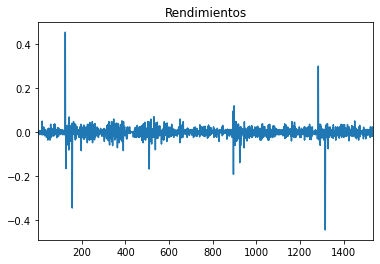

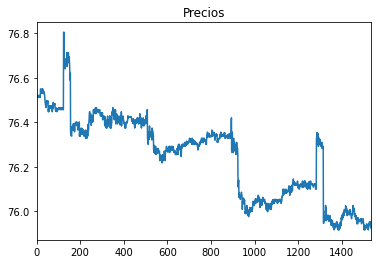

Slope: close   -0.000379
dtype: float64
Min: 75.9165, Max: 76.8051
Plotting [1, 0, 1, 4, 3]


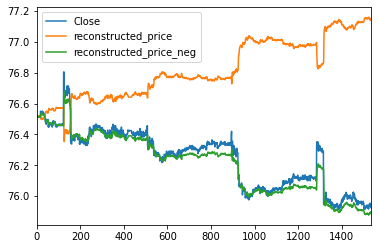

Plotting [2, 0, 7, 1, 4]


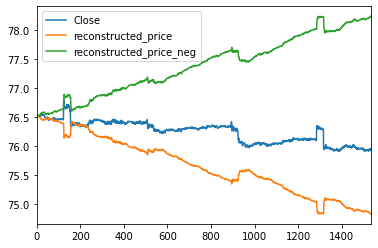

Plotting [3, 0, 5, 2, 4]


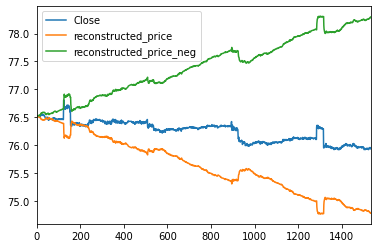

Plotting [4, 0, 6, 1, 3]


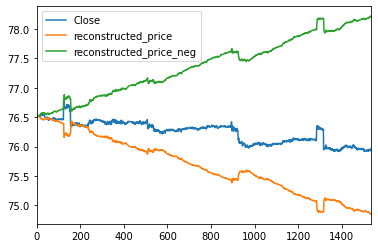

Plotting [5, 0, 16, 1, 3]


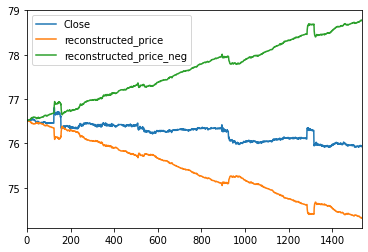

Plotting [6, 0, 3, 2, 2]


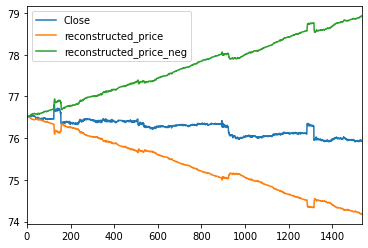

Plotting [7, 0, 3, 4, 1]


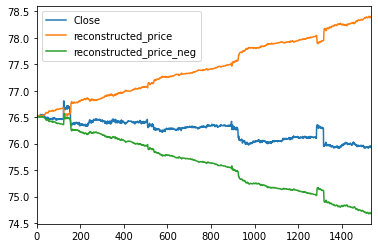

Plotting [8, 0, 10, 2, 3]


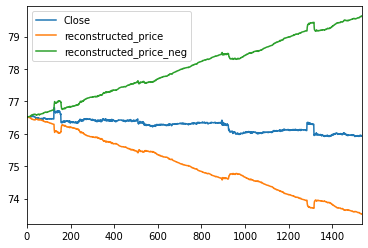

Plotting [9, 0, 16, 2, 2]


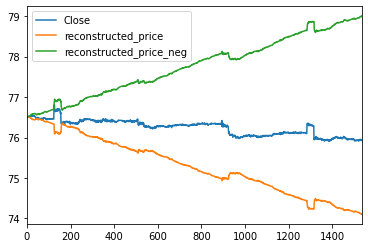

Plotting [10, 0, 11, 1, 3]


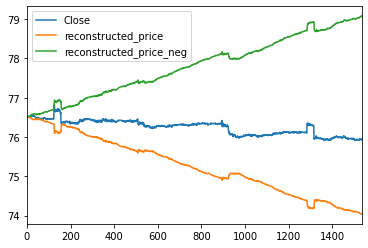

Plotting [11, 0, 17, 1, 3]


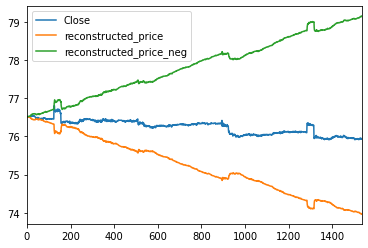

Plotting [12, 0, 9, 4, 1]


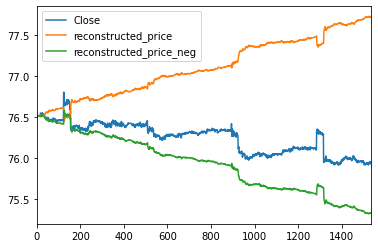

Plotting [13, 0, 16, 1, 3]


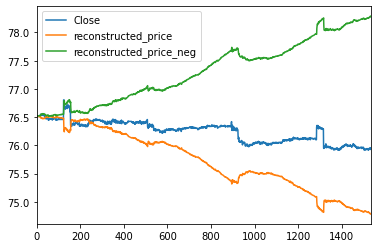

Plotting [14, 0, 15, 1, 1]


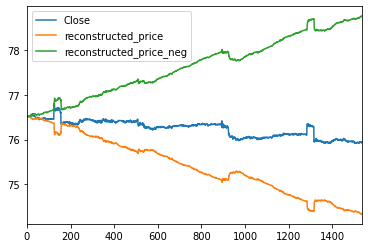

Plotting [15, 0, 13, 3, 2]


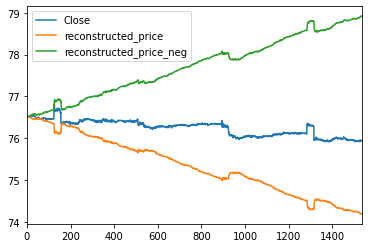

Plotting [16, 0, 10, 1, 2]


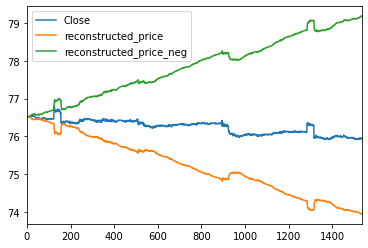

Plotting [17, 0, 11, 1, 1]


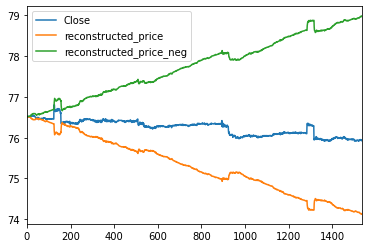

Plotting [18, 0, 8, 1, 1]


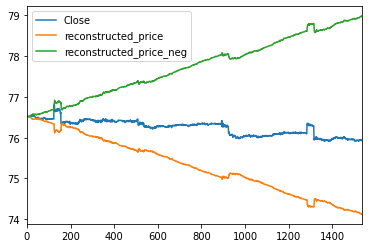

C:\Users\suare\data\list\whitelisted\sets\iwm20171011T1854.csv
C:\Users\suare\data\list\whitelisted\sets\iwo20170607T1613.csv
C:\Users\suare\data\list\whitelisted\sets\mdy20180911T1138.csv
C:\Users\suare\data\tmp\selection\spxl20180524T1550.csv
C:\Users\suare\data\tmp\selection\vv20171101T1523.csv


In [31]:
# for GLD
orders_df = pd.read_csv('C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\logs\\concated.csv', sep=';')
orders_df['orders'] = orders_df['orders'].apply(lambda x: x.split(','))
multiplier = 5

superposed_list = [()]
superposed = False

for path in list(orders_df.FILEPATH.unique()):
    print(path)
    if 'biv' in path:
        best_orders = list(orders_df[orders_df.FILEPATH==path].orders)
        print(best_orders)

        # 1. Load close prices
        fpattern = path
        df = pd.read_csv(fpattern, sep=',')
        returns = 100 * df['close'].pct_change().dropna()   # pct_change es para rendimientos
        returns.plot(title="Rendimientos")
        plt.show()
        prices = df['close'].dropna() 
        prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
        plt.show()
        slope = df[['close']].dropna().apply(lambda x: np.polyfit(df.index, x, 1)[0])
        # slopes.plot(title='Slope', label ='Time') 
        print(f'Slope: {slope}')
        data =  prices

        # 2. Standardize / convert to returns
        mode = 'returns'
        # train the standardization
        df = data.to_frame()
        min_max_scaler = MinMaxScaler()
        min_max_scaler = min_max_scaler.fit(df)
        print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 
        if mode=='returns':    
            TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True) #.dropna().reset_index(drop=True)
        else:     
            # standardization the dataset (don't use prices as these are auto correlated)
            TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
        TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)     

        if superposed:
            best_orders = superposed_list
        
        # 3 Iterate through best orders
        for (p_, n, q_, g_p, g_q) in best_orders:

            print(f'Plotting [{p_}, 0, {q_}, {g_p}, {g_q}]')
            try:
                # Initialize R GARCH model
                garch_spec = rugarch.ugarchspec(
                    # Using student T distribution usually provides better fit
                    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), 
                    # Using student T distribution usually provides better fit
                    variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
                    distribution_model='sged')  # 'std'

                # Used to convert training set to R list for model input
                numpy2ri.activate()
                forecast_horizon = 1

                # Train R GARCH model on returns as %
                garch_fitted = rugarch.ugarchfit(
                    spec=garch_spec,
                    data=np.array(TS),
                    out_sample=forecast_horizon
                )
                numpy2ri.deactivate()

                # print(garch_fitted)
                # print('Showing ARMA-GARCH coefficients:')
                # print(garch_fitted.slots['fit'].rx2('coef'))

                # Model's fitted standard deviation values
                fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
                minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

                # Forecast 
                garch_forecast = rugarch.ugarchforecast(
                    garch_fitted,
                    n_ahead=2,
                    n_roll=0, #forecast_horizon - 1
                )

                # Model's forecasted standard deviation values
                forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
                forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

                # how to reconstruct prices
                df = pd.DataFrame() 
                df['Close'] = data[:-forecast_horizon] # data
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                df['ts_logr_na0'] = TS
                df['logr_na0'] = fitted  # TS

                # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
                # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
                df['cuml_log']= np.cumsum(df.logr_na0 * 1) # 1
                df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
                df['cuml_log_negative']= np.cumsum(df.logr_na0 * -1) # 1
                df['reconstructed_price_norm_neg'] = np.exp(df.cuml_log_negative) # 2
                # multiplicamos todos los valores por dicho valor y listo.
                df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
                df['reconstructed_price_neg'] = df['Close'].values[0] * df.reconstructed_price_norm_neg
                df['reconstructed_price'] = df['reconstructed_price'].astype(float)
                df['reconstructed_price_neg'] = df['reconstructed_price_neg'].astype(float)
                # df

                # making sure that the model adaps well
                df[['Close','reconstructed_price', 'reconstructed_price_neg']].plot()
                fitted_reconstructed = df['reconstructed_price']
                plt.show();
                # df
            except:
                print('Error reconstructing prices')

In [ ]:
# for GLD
orders_df = pd.read_csv('C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\logs\\concated.csv', sep=';')
orders_df['orders'] = orders_df['orders'].apply(lambda x: x.split(','))
multiplier = 5

superposed_list = [(20,0,26,5,5), (20,0,56,2,2), (44,0,33,2,2), (65,0,48,2,2), (44,0,87,2,2), (22,0,15,2,2)]
superpose = True

for path in list(orders_df.FILEPATH.unique()):
    print(path)
    if 'spxl' in path:
        best_orders = list(orders_df[orders_df.FILEPATH==path].orders)
        print(best_orders)

        # 1. Load close prices
        fpattern = path
        df = pd.read_csv(fpattern, sep=',')
        returns = 100 * df['close'].pct_change().dropna()   # pct_change es para rendimientos
        returns.plot(title="Rendimientos")
        plt.show()
        prices = df['close'].dropna() 
        prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
        plt.show()
        slope = df[['close']].dropna().apply(lambda x: np.polyfit(df.index, x, 1)[0])
        # slopes.plot(title='Slope', label ='Time') 
        print(f'Slope: {slope}')
        data =  prices

        # 2. Standardize / convert to returns
        mode = 'returns'
        # train the standardization
        df = data.to_frame()
        min_max_scaler = MinMaxScaler()
        min_max_scaler = min_max_scaler.fit(df)
        print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 
        if mode=='returns':    
            TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True) #.dropna().reset_index(drop=True)
        else:     
            # standardization the dataset (don't use prices as these are auto correlated)
            TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
        TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)     

        if superpose:
            best_orders = superposed_list
        
        # 3 Iterate through best orders
        for (p_, n, q_, g_p, g_q) in best_orders:

            print(f'Plotting [{p_}, 0, {q_}, {g_p}, {g_q}]')
#             try:
                # Initialize R GARCH model
                garch_spec = rugarch.ugarchspec(
                    # Using student T distribution usually provides better fit
                    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), 
                    # Using student T distribution usually provides better fit
                    variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
                    distribution_model='sged')  # 'std'

                # Used to convert training set to R list for model input
                numpy2ri.activate()
                forecast_horizon = 1

                # Train R GARCH model on returns as %
                garch_fitted = rugarch.ugarchfit(
                    spec=garch_spec,
                    data=np.array(TS),
                    out_sample=forecast_horizon
                )
                numpy2ri.deactivate()

                # print(garch_fitted)
                # print('Showing ARMA-GARCH coefficients:')
                # print(garch_fitted.slots['fit'].rx2('coef'))

                # Model's fitted standard deviation values
                fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
                minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

                # Forecast 
                garch_forecast = rugarch.ugarchforecast(
                    garch_fitted,
                    n_ahead=2,
                    n_roll=0, #forecast_horizon - 1
                )

                # Model's forecasted standard deviation values
                forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
                forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()
                print('Ready to plot')

                # how to reconstruct prices
                df = pd.DataFrame() 
                df['Close'] = data[:-forecast_horizon] # data
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                df['ts_logr_na0'] = TS
                df['logr_na0'] = fitted  # TS

                # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
                # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
                df['cuml_log']= np.cumsum(df.logr_na0 * 1) # 1
                df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
                df['cuml_log_negative']= np.cumsum(df.logr_na0 * -1) # 1
                df['reconstructed_price_norm_neg'] = np.exp(df.cuml_log_negative) # 2
                # multiplicamos todos los valores por dicho valor y listo.
                df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
                df['reconstructed_price_neg'] = df['Close'].values[0] * df.reconstructed_price_norm_neg
                df['reconstructed_price'] = df['reconstructed_price'].astype(float)
                df['reconstructed_price_neg'] = df['reconstructed_price_neg'].astype(float)
                # df

                # making sure that the model adaps well
                df[['Close','reconstructed_price', 'reconstructed_price_neg']].plot()
                fitted_reconstructed = df['reconstructed_price']
                plt.show();
                # df
#             except:
#                 print('Error reconstructing prices')

C:\Users\suare\data\list\whitelisted\sets\biv20170210T1354.csv
[['1', '0', '1', '4', '3'], ['2', '0', '7', '1', '4'], ['3', '0', '5', '2', '4'], ['4', '0', '6', '1', '3'], ['5', '0', '16', '1', '3'], ['6', '0', '3', '2', '2'], ['7', '0', '3', '4', '1'], ['8', '0', '10', '2', '3'], ['9', '0', '16', '2', '2'], ['10', '0', '11', '1', '3'], ['11', '0', '17', '1', '3'], ['12', '0', '9', '4', '1'], ['13', '0', '16', '1', '3'], ['14', '0', '15', '1', '1'], ['15', '0', '13', '3', '2'], ['16', '0', '10', '1', '2'], ['17', '0', '11', '1', '1'], ['18', '0', '8', '1', '1']]


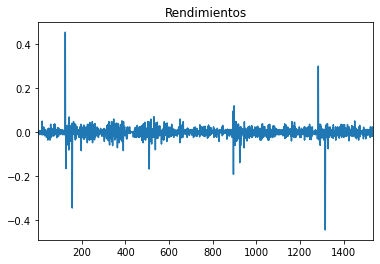

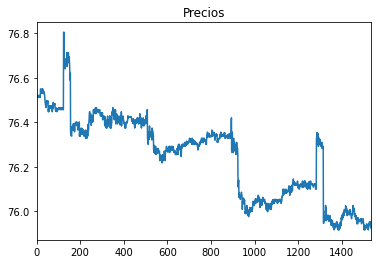

Slope: close   -0.000379
dtype: float64
Min: 75.9165, Max: 76.8051
Plotting [30, 0, 18, 2, 2]


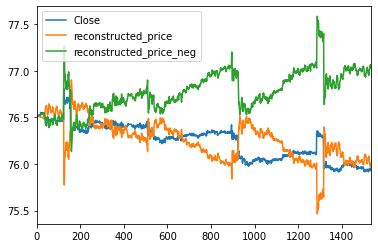

Plotting [30, 0, 17, 2, 2]


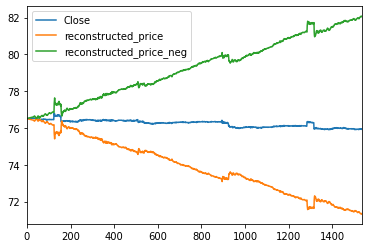

Plotting [30, 0, 17, 2, 2]


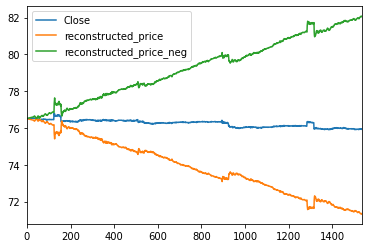

Plotting [35, 0, 18, 2, 2]
Error reconstructing prices
C:\Users\suare\data\list\whitelisted\sets\iwm20171011T1854.csv
C:\Users\suare\data\list\whitelisted\sets\iwo20170607T1613.csv
C:\Users\suare\data\list\whitelisted\sets\mdy20180911T1138.csv
C:\Users\suare\data\tmp\selection\spxl20180524T1550.csv
C:\Users\suare\data\tmp\selection\vv20171101T1523.csv


In [115]:
# for GLD
orders_df = pd.read_csv('C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\logs\\concated.csv', sep=';')
orders_df['orders'] = orders_df['orders'].apply(lambda x: x.split(','))
multiplier = 4

# superposed_list = [(40, 0, 1, 5, 4)]
superposed_list = [(30, 0, 18, 2,2), (30, 0, 17, 2,2), (30, 0, 17, 2,2), (35, 0, 18, 2,2)]
superpose = True

for path in list(orders_df.FILEPATH.unique()):
    print(path)
    if 'biv' in path:
        best_orders = list(orders_df[orders_df.FILEPATH==path].orders)
        print(best_orders)

        # 1. Load close prices
        fpattern = path
        df = pd.read_csv(fpattern, sep=',')
        returns = 100 * df['close'].pct_change().dropna()   # pct_change es para rendimientos
        returns.plot(title="Rendimientos")
        plt.show()
        prices = df['close'].dropna() 
        prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
        plt.show()
        slope = df[['close']].dropna().apply(lambda x: np.polyfit(df.index, x, 1)[0])
        # slopes.plot(title='Slope', label ='Time') 
        print(f'Slope: {slope}')
        data =  prices

        # 2. Standardize / convert to returns
        mode = 'returns'
        # train the standardization
        df = data.to_frame()
        min_max_scaler = MinMaxScaler()
        min_max_scaler = min_max_scaler.fit(df)
        print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 
        if mode=='returns':    
            TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True) #.dropna().reset_index(drop=True)
        else:     
            # standardization the dataset (don't use prices as these are auto correlated)
            TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
        TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)     

        if superpose:
            best_orders = superposed_list
            
        # 3 Iterate through best orders
        for (p_, n, q_, g_p, g_q) in best_orders:

            print(f'Plotting [{p_}, 0, {q_}, {g_p}, {g_q}]')
            try:
                # Initialize R GARCH model
                garch_spec = rugarch.ugarchspec(
                    # Using student T distribution usually provides better fit
                    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), 
                    # Using student T distribution usually provides better fit
                    variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
                    distribution_model='sged')  # 'std'

                # Used to convert training set to R list for model input
                numpy2ri.activate()
                forecast_horizon = 1

                # Train R GARCH model on returns as %
                garch_fitted = rugarch.ugarchfit(
                    spec=garch_spec,
                    data=np.array(TS),
                    out_sample=forecast_horizon
                )
                numpy2ri.deactivate()

            
                # print(garch_fitted)
                # print('Showing ARMA-GARCH coefficients:')
                # print(garch_fitted.slots['fit'].rx2('coef'))

                # Model's fitted standard deviation values
                fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
                minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                
                
#                 output = pd.DataFrame({
#                     'actual': list(np.array(TS)),
#                     'model': np.append(fitted*multiplier, forecast*multiplier),
#                 })

#                 plt.plot(output['actual'][:-forecast_horizon], label='Train')
#                 plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
#                 plt.plot(output['model'][:-forecast_horizon], label='Fitted')
#                 plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
#                 plt.legend()
#                 plt.show();

                # Forecast 
                garch_forecast = rugarch.ugarchforecast(
                    garch_fitted,
                    n_ahead=2,
                    n_roll=0, #forecast_horizon - 1
                )

                # Model's forecasted standard deviation values
                forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
                forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

                # how to reconstruct prices
                df = pd.DataFrame() 
                df['Close'] = data[:-forecast_horizon] # data
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                df['ts_logr_na0'] = TS
                df['logr_na0'] = fitted  # TS

                # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
                # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
                df['cuml_log']= np.cumsum(df.logr_na0 * multiplier) # 1
                df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
                df['cuml_log_negative']= np.cumsum(df.logr_na0 * -1 * multiplier) # 1
                df['reconstructed_price_norm_neg'] = np.exp(df.cuml_log_negative) # 2
                # multiplicamos todos los valores por dicho valor y listo.
                df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
                df['reconstructed_price_neg'] = df['Close'].values[0] * df.reconstructed_price_norm_neg
                df['reconstructed_price'] = df['reconstructed_price'].astype(float)
                df['reconstructed_price_neg'] = df['reconstructed_price_neg'].astype(float)
                # df

                # making sure that the model adaps well
                df[['Close','reconstructed_price', 'reconstructed_price_neg']].plot()
                fitted_reconstructed = df['reconstructed_price']
                plt.show();
                # df
            except:
                print('Error reconstructing prices')

In [ ]:
for p in range(1, 50, 2):
    for q in range(1, 50, 2):
        for garch_pq in range(2, 2):
            superposed_list.append((p,0,q,garch_pq,garch_pq))
            

In [33]:
superposed_list = []
for p in range(1, 50, 3):
    for q in range(1, 50, 3):
        for garch_pq in range(2, 3): # just 2,2
            superposed_list.append((p,0,q,garch_pq,garch_pq))
superpose = True

In [34]:
len(superposed_list)

289

C:\Users\suare\data\list\whitelisted\sets\biv20170210T1354.csv
[['1', '0', '1', '4', '3'], ['2', '0', '7', '1', '4'], ['3', '0', '5', '2', '4'], ['4', '0', '6', '1', '3'], ['5', '0', '16', '1', '3'], ['6', '0', '3', '2', '2'], ['7', '0', '3', '4', '1'], ['8', '0', '10', '2', '3'], ['9', '0', '16', '2', '2'], ['10', '0', '11', '1', '3'], ['11', '0', '17', '1', '3'], ['12', '0', '9', '4', '1'], ['13', '0', '16', '1', '3'], ['14', '0', '15', '1', '1'], ['15', '0', '13', '3', '2'], ['16', '0', '10', '1', '2'], ['17', '0', '11', '1', '1'], ['18', '0', '8', '1', '1']]


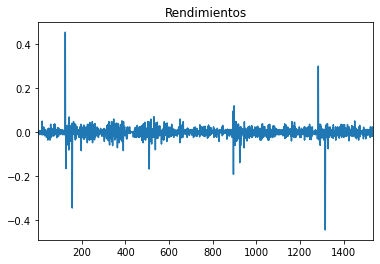

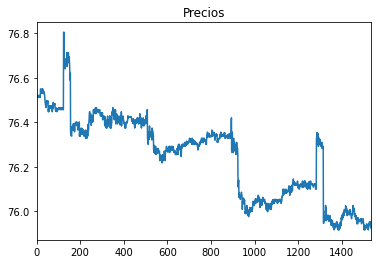

Slope: close   -0.000379
dtype: float64
Min: 75.9165, Max: 76.8051
Plotting 0: [1, 0, 1, 2, 2]
MAE is 0.41732687632979637
RMSE is 0.4883623821540645
#######################
Plotting 0: [1, 0, 4, 2, 2]
MAE is 0.13112109025902835
RMSE is 0.1625993295906475
#######################
Plotting 0: [1, 0, 7, 2, 2]
MAE is 0.25109079355913067
RMSE is 0.28994914387529624
#######################
Plotting 0: [1, 0, 10, 2, 2]
MAE is 0.3187894297442015
RMSE is 0.37559538506160933
#######################
Plotting 0: [1, 0, 13, 2, 2]
MAE is 0.1303111667413852
RMSE is 0.17256262653414453
#######################
Plotting 0: [1, 0, 16, 2, 2]
Error reconstructing prices
Plotting 0: [1, 0, 19, 2, 2]
MAE is 0.33282738398746387
RMSE is 0.39565897173145087
#######################
Plotting 0: [1, 0, 22, 2, 2]
MAE is 0.44712603757211467
RMSE is 0.5320684349518479
#######################
Plotting 0: [1, 0, 25, 2, 2]
MAE is 0.09786826756198704
RMSE is 0.125565615392898
#######################
Plotting 0: [1, 0, 28,

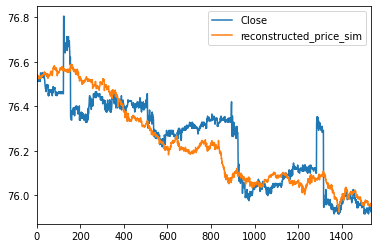

#######################
Plotting 0: [1, 0, 37, 2, 2]
MAE is 0.1857816568026155
RMSE is 0.21733866293556278
#######################
Plotting 0: [1, 0, 40, 2, 2]
Error reconstructing prices
Plotting 0: [1, 0, 43, 2, 2]
MAE is 0.17108764722637984
RMSE is 0.19259737024160065
#######################
Plotting 0: [1, 0, 46, 2, 2]
MAE is 0.24176465986742227
RMSE is 0.278518103002486
#######################
Plotting 0: [1, 0, 49, 2, 2]
MAE is 0.08903131754561795
RMSE is 0.11503292087976857
#######################
Plotting 0: [4, 0, 1, 2, 2]
MAE is 0.2178801685133467
RMSE is 0.24809636014618724
#######################
Plotting 0: [4, 0, 4, 2, 2]
MAE is 0.21378101280066827
RMSE is 0.25680137875331155
#######################
Plotting 0: [4, 0, 7, 2, 2]
MAE is 0.17016290330706374
RMSE is 0.21705642966886532
#######################
Plotting 0: [4, 0, 10, 2, 2]
MAE is 0.07964692842187339
RMSE is 0.1064893833384017


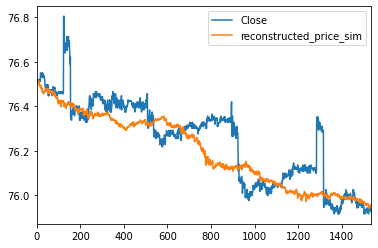

#######################
Plotting 0: [4, 0, 13, 2, 2]
MAE is 0.17039157057439103
RMSE is 0.20140103496051956
#######################
Plotting 0: [4, 0, 16, 2, 2]
MAE is 0.4199046622759926
RMSE is 0.49132738012612653
#######################
Plotting 0: [4, 0, 19, 2, 2]
MAE is 0.5427659967846795
RMSE is 0.6327749308459812
#######################
Plotting 0: [4, 0, 22, 2, 2]
MAE is 0.2025439077428495
RMSE is 0.25495832237269117
#######################
Plotting 0: [4, 0, 25, 2, 2]
MAE is 0.23679361315383105
RMSE is 0.27241019509032527
#######################
Plotting 0: [4, 0, 28, 2, 2]
MAE is 0.07567809850060363
RMSE is 0.09952362933313172


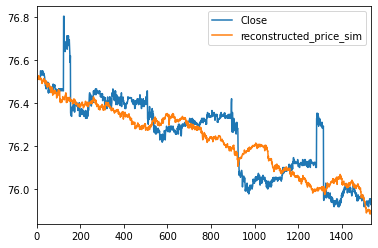

In [ ]:
from sklearn import metrics

# for GLD
orders_df = pd.read_csv('C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\logs\\concated.csv', sep=';')
orders_df['orders'] = orders_df['orders'].apply(lambda x: x.split(','))
multiplier = 1

# superposed_list = [(40, 0, 1, 5, 4)]
# superposed_list = [(40, 0, 18, 2,2), (20, 0, 18, 2,2),  (26, 0, 26, 2,2), (30, 0, 18, 2,2)]


superposed_list = []
for p in range(1, 50, 3):
    for q in range(1, 50, 3):
        for garch_pq in range(2, 3): # just 2,2
            superposed_list.append((p,0,q,garch_pq,garch_pq))
superpose = True

for path in list(orders_df.FILEPATH.unique()):
    print(path)
    if 'biv' in path:
        best_orders = list(orders_df[orders_df.FILEPATH==path].orders)
        print(best_orders)

        # 1. Load close prices
        fpattern = path
        df = pd.read_csv(fpattern, sep=',')
        returns = 100 * df['close'].pct_change().dropna()   # pct_change es para rendimientos
        returns.plot(title="Rendimientos")
        plt.show()
        prices = df['close'].dropna() 
        prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
        plt.show()
        slope = df[['close']].dropna().apply(lambda x: np.polyfit(df.index, x, 1)[0])
        # slopes.plot(title='Slope', label ='Time') 
        print(f'Slope: {slope}')
        data =  prices

        # 2. Standardize / convert to returns
        mode = 'returns'
        # train the standardization
        df = data.to_frame()
        min_max_scaler = MinMaxScaler()
        min_max_scaler = min_max_scaler.fit(df)
        print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 
        if mode=='returns':    
            TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True) #.dropna().reset_index(drop=True)
        else:     
            # standardization the dataset (don't use prices as these are auto correlated)
            TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
        TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)     

        if superpose:
            best_orders = superposed_list
            
        # 3 Iterate through best orders
        j = 0
        for (p_, n, q_, g_p, g_q) in best_orders:
            print(f'Plotting {j}: [{p_}, 0, {q_}, {g_p}, {g_q}]')
            try:
                # Initialize R GARCH model
                garch_spec = rugarch.ugarchspec(
                    # Using student T distribution usually provides better fit
                    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), 
                    # Using student T distribution usually provides better fit
                    variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
                    distribution_model='sged')  # 'std'

                # Used to convert training set to R list for model input
                numpy2ri.activate()
                forecast_horizon = 1

                # Train R GARCH model on returns as %
                garch_fitted = rugarch.ugarchfit(
                    spec=garch_spec,
                    data=np.array(TS),
                    out_sample=forecast_horizon
                )
                numpy2ri.deactivate()

            
                # print(garch_fitted)
                # print('Showing ARMA-GARCH coefficients:')
                # print(garch_fitted.slots['fit'].rx2('coef'))

                # Model's fitted standard deviation values
                fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
                minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                
                
#                 output = pd.DataFrame({
#                     'actual': list(np.array(TS)),
#                     'model': np.append(fitted*multiplier, forecast*multiplier),
#                 })

#                 plt.plot(output['actual'][:-forecast_horizon], label='Train')
#                 plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
#                 plt.plot(output['model'][:-forecast_horizon], label='Fitted')
#                 plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
#                 plt.legend()
#                 plt.show();

                # Forecast 
#                 garch_forecast = rugarch.ugarchforecast(
#                     garch_fitted,
#                     n_ahead=2,
#                     n_roll=0, #forecast_horizon - 1
#                 )
                garch_simulation = rugarch.ugarchsim(garch_fitted,
                                             n_sim=len(TS),
                                             m_sim=1)#, prereturns=[1,1,1,1,1,1,1,1]) # ts[-roll:] if len(ts) > roll else ts)

                # Model's forecasted standard deviation values
                forecasted_minute_volatility = np.array(garch_simulation.slots['simulation'].rx2('sigmaSim')).flatten()
                forecast = np.array(garch_simulation.slots['simulation'].rx2('seriesSim')).flatten()

                # how to reconstruct prices
                df = pd.DataFrame() 
                df['Close'] = data[:-forecast_horizon] # data
#                 fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
#                 df['ts_logr_na0'] = TS
#                 df['logr_na0'] = fitted  # TS
                df['logr_na0_sim'] = forecast[:len(TS)-1]  # TS

                # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
                # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
#                 df['cuml_log']= np.cumsum(df.logr_na0 * multiplier) # 1
#                 df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
#                 df['cuml_log_negative']= np.cumsum(df.logr_na0 * -1 * multiplier) # 1
#                 df['reconstructed_price_norm_neg'] = np.exp(df.cuml_log_negative) # 2
                df['cuml_log_sim']= np.cumsum(df.logr_na0_sim * multiplier) # 1
                df['reconstructed_price_norm_sim'] = np.exp(df.cuml_log_sim) # 2
                # multiplicamos todos los valores por dicho valor y listo.
#                 df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
#                 df['reconstructed_price_neg'] = df['Close'].values[0] * df.reconstructed_price_norm_neg
                df['reconstructed_price_sim'] = df['Close'].values[0] * df.reconstructed_price_norm_sim
#                 df['reconstructed_price'] = df['reconstructed_price'].astype(float)
#                 df['reconstructed_price_neg'] = df['reconstructed_price_neg'].astype(float)
                df['reconstructed_price_sim'] = df['reconstructed_price_sim'].astype(float)

                # df

                # making sure that the model adaps well
                # df[['Close','reconstructed_price', 'reconstructed_price_neg', 'reconstructed_price_sim']].plot()
#                 df[['Close','reconstructed_price_sim']].plot()
#                 fitted_reconstructed = df['reconstructed_price']
#                 fitted_reconstructed = df['reconstructed_price_sim']
                print(f'MAE is {metrics.mean_absolute_error(np.array(df.Close), np.array(df.reconstructed_price_sim))}')
                rmse = np.sqrt(metrics.mean_squared_error(np.array(df.Close), np.array(df.reconstructed_price_sim)))
                print(f'RMSE is {rmse}')
                if rmse < 0.11:
                    df[['Close','reconstructed_price_sim']].plot()
                    plt.show();
                print('#######################')
                # df
            except:
                print('Error reconstructing prices')
            j = j + 0

In [ ]:
from sklearn import metrics

# for GLD
orders_df = pd.read_csv('C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\logs\\concated.csv', sep=';')
orders_df['orders'] = orders_df['orders'].apply(lambda x: x.split(','))
multiplier = 1

# superposed_list = [(40, 0, 1, 5, 4)]
# superposed_list = [(40, 0, 18, 2,2), (20, 0, 18, 2,2),  (26, 0, 26, 2,2), (30, 0, 18, 2,2)]


superposed_list = []
for p in range(10, 40, 1):
    for q in range(1, 50, 1):
        for garch_pq in range(1, 3): # just 2,2
            superposed_list.append((p,0,q,garch_pq,garch_pq))
superpose = True

for path in list(orders_df.FILEPATH.unique()):
    print(path)
    if 'biv' in path:
        best_orders = list(orders_df[orders_df.FILEPATH==path].orders)
        print(best_orders)

        # 1. Load close prices
        fpattern = path
        df = pd.read_csv(fpattern, sep=',')
        returns = 100 * df['close'].pct_change().dropna()   # pct_change es para rendimientos
        returns.plot(title="Rendimientos")
        plt.show()
        prices = df['close'].dropna() 
        prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
        plt.show()
        slope = df[['close']].dropna().apply(lambda x: np.polyfit(df.index, x, 1)[0])
        # slopes.plot(title='Slope', label ='Time') 
        print(f'Slope: {slope}')
        data =  prices

        # 2. Standardize / convert to returns
        mode = 'returns'
        # train the standardization
        df = data.to_frame()
        min_max_scaler = MinMaxScaler()
        min_max_scaler = min_max_scaler.fit(df)
        print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 
        if mode=='returns':    
            TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True) #.dropna().reset_index(drop=True)
        else:     
            # standardization the dataset (don't use prices as these are auto correlated)
            TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
        TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)     

        if superpose:
            best_orders = superposed_list
            
        # 3 Iterate through best orders
        j = 0
        for (p_, n, q_, g_p, g_q) in best_orders:
            print(f'Plotting {j}: [{p_}, 0, {q_}, {g_p}, {g_q}]')
            try:
                # Initialize R GARCH model
                garch_spec = rugarch.ugarchspec(
                    # Using student T distribution usually provides better fit
                    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), 
                    # Using student T distribution usually provides better fit
                    variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
                    distribution_model='sged')  # 'std'

                # Used to convert training set to R list for model input
                numpy2ri.activate()
                forecast_horizon = 1

                # Train R GARCH model on returns as %
                garch_fitted = rugarch.ugarchfit(
                    spec=garch_spec,
                    data=np.array(TS),
                    out_sample=forecast_horizon
                )
                numpy2ri.deactivate()

            
                # print(garch_fitted)
                # print('Showing ARMA-GARCH coefficients:')
                # print(garch_fitted.slots['fit'].rx2('coef'))

                # Model's fitted standard deviation values
                fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
                minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                
                
#                 output = pd.DataFrame({
#                     'actual': list(np.array(TS)),
#                     'model': np.append(fitted*multiplier, forecast*multiplier),
#                 })

#                 plt.plot(output['actual'][:-forecast_horizon], label='Train')
#                 plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
#                 plt.plot(output['model'][:-forecast_horizon], label='Fitted')
#                 plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
#                 plt.legend()
#                 plt.show();

                # Forecast 
#                 garch_forecast = rugarch.ugarchforecast(
#                     garch_fitted,
#                     n_ahead=2,
#                     n_roll=0, #forecast_horizon - 1
#                 )
                garch_simulation = rugarch.ugarchsim(garch_fitted,
                                             n_sim=len(TS),
                                             m_sim=1)#, prereturns=[1,1,1,1,1,1,1,1]) # ts[-roll:] if len(ts) > roll else ts)

                # Model's forecasted standard deviation values
                forecasted_minute_volatility = np.array(garch_simulation.slots['simulation'].rx2('sigmaSim')).flatten()
                forecast = np.array(garch_simulation.slots['simulation'].rx2('seriesSim')).flatten()

                # how to reconstruct prices
                df = pd.DataFrame() 
                df['Close'] = data[:-forecast_horizon] # data
#                 fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
#                 df['ts_logr_na0'] = TS
#                 df['logr_na0'] = fitted  # TS
                df['logr_na0_sim'] = forecast[:len(TS)-1]  # TS

                # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
                # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
#                 df['cuml_log']= np.cumsum(df.logr_na0 * multiplier) # 1
#                 df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
#                 df['cuml_log_negative']= np.cumsum(df.logr_na0 * -1 * multiplier) # 1
#                 df['reconstructed_price_norm_neg'] = np.exp(df.cuml_log_negative) # 2
                df['cuml_log_sim']= np.cumsum(df.logr_na0_sim * multiplier) # 1
                df['reconstructed_price_norm_sim'] = np.exp(df.cuml_log_sim) # 2
                # multiplicamos todos los valores por dicho valor y listo.
#                 df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
#                 df['reconstructed_price_neg'] = df['Close'].values[0] * df.reconstructed_price_norm_neg
                df['reconstructed_price_sim'] = df['Close'].values[0] * df.reconstructed_price_norm_sim
#                 df['reconstructed_price'] = df['reconstructed_price'].astype(float)
#                 df['reconstructed_price_neg'] = df['reconstructed_price_neg'].astype(float)
                df['reconstructed_price_sim'] = df['reconstructed_price_sim'].astype(float)

                # df

                # making sure that the model adaps well
                # df[['Close','reconstructed_price', 'reconstructed_price_neg', 'reconstructed_price_sim']].plot()
#                 df[['Close','reconstructed_price_sim']].plot()
#                 fitted_reconstructed = df['reconstructed_price']
#                 fitted_reconstructed = df['reconstructed_price_sim']
                print(f'MAE is {metrics.mean_absolute_error(np.array(df.Close), np.array(df.reconstructed_price_sim))}')
                rmse = np.sqrt(metrics.mean_squared_error(np.array(df.Close), np.array(df.reconstructed_price_sim)))
                print(f'RMSE is {rmse}')
                if rmse < 0.14:
                    df[['Close','reconstructed_price_sim']].plot()
                    plt.show();
                print('#######################')
                # df
            except:
                print('Error reconstructing prices')
            j = j + 0

In [10]:
len(forecast)

1537

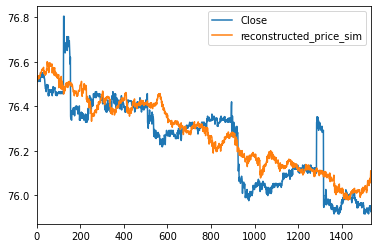

In [17]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted  # TS
df['logr_na0_sim'] = forecast[:len(TS)-1]  # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0 * multiplier) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
df['cuml_log_negative']= np.cumsum(df.logr_na0 * -1 * multiplier) # 1
df['reconstructed_price_norm_neg'] = np.exp(df.cuml_log_negative) # 2
df['cuml_log_sim']= np.cumsum(df.logr_na0_sim * multiplier) # 1
df['reconstructed_price_norm_sim'] = np.exp(df.cuml_log_sim) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price_neg'] = df['Close'].values[0] * df.reconstructed_price_norm_neg
df['reconstructed_price_sim'] = df['Close'].values[0] * df.reconstructed_price_norm_sim
df['reconstructed_price'] = df['reconstructed_price'].astype(float)
df['reconstructed_price_neg'] = df['reconstructed_price_neg'].astype(float)
df['reconstructed_price_sim'] = df['reconstructed_price_sim'].astype(float)

# df

# making sure that the model adaps well
# df[['Close','reconstructed_price', 'reconstructed_price_neg', 'reconstructed_price_sim']].plot()
df[['Close','reconstructed_price_sim']].plot()
fitted_reconstructed = df['reconstructed_price']
fitted_reconstructed = df['reconstructed_price_sim']
plt.show();

In [ ]:
30, 0, 18, 2, 2

C:\Users\suare\data\list\whitelisted\sets\biv20170210T1354.csv
C:\Users\suare\data\list\whitelisted\sets\iwm20171011T1854.csv
C:\Users\suare\data\list\whitelisted\sets\iwo20170607T1613.csv
C:\Users\suare\data\list\whitelisted\sets\mdy20180911T1138.csv
C:\Users\suare\data\tmp\selection\spxl20180524T1550.csv
[['1', '0', '1', '1', '2'], ['2', '0', '1', '1', '1'], ['3', '0', '1', '1', '1'], ['4', '0', '2', '1', '3'], ['5', '0', '1', '1', '1'], ['6', '0', '6', '1', '1'], ['7', '0', '8', '1', '2'], ['8', '0', '15', '1', '1'], ['9', '0', '8', '1', '3'], ['10', '0', '10', '2', '1'], ['11', '0', '6', '1', '1'], ['12', '0', '17', '1', '1'], ['13', '0', '12', '2', '3'], ['14', '0', '15', '1', '2'], ['15', '0', '18', '2', '2'], ['16', '0', '17', '1', '3'], ['17', '0', '20', '2', '1'], ['18', '0', '10', '1', '2'], ['19', '0', '15', '3', '2'], ['20', '0', '17', '2', '2']]


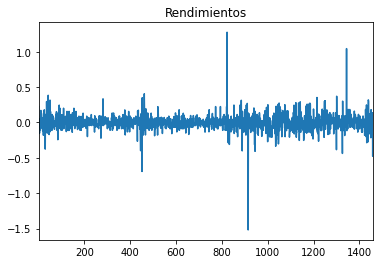

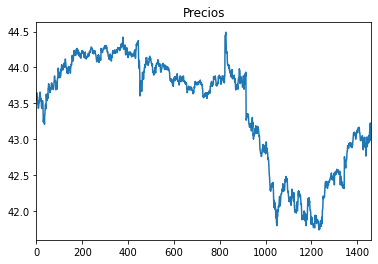

Slope: close   -0.001428
dtype: float64
Min: 41.7319, Max: 44.4904
Plotting [20, 0, 17, 2, 2]


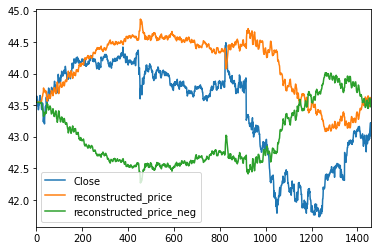

C:\Users\suare\data\tmp\selection\vv20171101T1523.csv


In [22]:
# for GLD
orders_df = pd.read_csv('C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\logs\\concated.csv', sep=';')
orders_df['orders'] = orders_df['orders'].apply(lambda x: x.split(','))
multiplier = 2.5

# superposed_list = [(40, 0, 1, 5, 4)]
# superposed_list = [(20, 0, 17, 2, 2)]
superpose = True

for path in list(orders_df.FILEPATH.unique()):
    print(path)
    if 'spxl' in path:
        best_orders = list(orders_df[orders_df.FILEPATH==path].orders)
        print(best_orders)

        # 1. Load close prices
        fpattern = path
        df = pd.read_csv(fpattern, sep=',')
        returns = 100 * df['close'].pct_change().dropna()   # pct_change es para rendimientos
        returns.plot(title="Rendimientos")
        plt.show()
        prices = df['close'].dropna() 
        prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
        plt.show()
        slope = df[['close']].dropna().apply(lambda x: np.polyfit(df.index, x, 1)[0])
        # slopes.plot(title='Slope', label ='Time') 
        print(f'Slope: {slope}')
        data =  prices

        # 2. Standardize / convert to returns
        mode = 'returns'
        # train the standardization
        df = data.to_frame()
        min_max_scaler = MinMaxScaler()
        min_max_scaler = min_max_scaler.fit(df)
        print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 
        if mode=='returns':    
            TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True) #.dropna().reset_index(drop=True)
        else:     
            # standardization the dataset (don't use prices as these are auto correlated)
            TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
        TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)     

        if superpose:
            best_orders = superposed_list
            
        # 3 Iterate through best orders
        for (p_, n, q_, g_p, g_q) in best_orders:

            print(f'Plotting [{p_}, 0, {q_}, {g_p}, {g_q}]')
            try:
                # Initialize R GARCH model
                garch_spec = rugarch.ugarchspec(
                    # Using student T distribution usually provides better fit
                    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), 
                    # Using student T distribution usually provides better fit
                    variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
                    distribution_model='sged')  # 'std'

                # Used to convert training set to R list for model input
                numpy2ri.activate()
                forecast_horizon = 1

                # Train R GARCH model on returns as %
                garch_fitted = rugarch.ugarchfit(
                    spec=garch_spec,
                    data=np.array(TS),
                    out_sample=forecast_horizon
                )
                numpy2ri.deactivate()

            
                # print(garch_fitted)
                # print('Showing ARMA-GARCH coefficients:')
                # print(garch_fitted.slots['fit'].rx2('coef'))

                # Model's fitted standard deviation values
                fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
                minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                
                
#                 output = pd.DataFrame({
#                     'actual': list(np.array(TS)),
#                     'model': np.append(fitted*multiplier, forecast*multiplier),
#                 })

#                 plt.plot(output['actual'][:-forecast_horizon], label='Train')
#                 plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
#                 plt.plot(output['model'][:-forecast_horizon], label='Fitted')
#                 plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
#                 plt.legend()
#                 plt.show();

                # Forecast 
                garch_forecast = rugarch.ugarchforecast(
                    garch_fitted,
                    n_ahead=2,
                    n_roll=0, #forecast_horizon - 1
                )

                # Model's forecasted standard deviation values
                forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
                forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

                # how to reconstruct prices
                df = pd.DataFrame() 
                df['Close'] = data[:-forecast_horizon] # data
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                df['ts_logr_na0'] = TS
                df['logr_na0'] = fitted  # TS

                # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
                # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
                df['cuml_log']= np.cumsum(df.logr_na0 * multiplier) # 1
                df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
                df['cuml_log_negative']= np.cumsum(df.logr_na0 * -1 * multiplier) # 1
                df['reconstructed_price_norm_neg'] = np.exp(df.cuml_log_negative) # 2
                # multiplicamos todos los valores por dicho valor y listo.
                df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
                df['reconstructed_price_neg'] = df['Close'].values[0] * df.reconstructed_price_norm_neg
                df['reconstructed_price'] = df['reconstructed_price'].astype(float)
                df['reconstructed_price_neg'] = df['reconstructed_price_neg'].astype(float)
                # df

                # making sure that the model adaps well
                df[['Close','reconstructed_price', 'reconstructed_price_neg']].plot()
                fitted_reconstructed = df['reconstructed_price']
                plt.show();
                # df
            except:
                print('Error reconstructing prices')

C:\Users\suare\data\list\whitelisted\sets\biv20170210T1354.csv
C:\Users\suare\data\list\whitelisted\sets\iwm20171011T1854.csv
C:\Users\suare\data\list\whitelisted\sets\iwo20170607T1613.csv
[['1', '0', '15', '3', '2'], ['2', '0', '18', '1', '3'], ['3', '0', '16', '3', '1'], ['4', '0', '17', '4', '2'], ['5', '0', '13', '2', '2'], ['6', '0', '18', '2', '1'], ['7', '0', '18', '1', '2'], ['8', '0', '18', '2', '1'], ['9', '0', '7', '3', '2'], ['10', '0', '11', '2', '2'], ['11', '0', '5', '2', '3'], ['12', '0', '9', '2', '1'], ['13', '0', '16', '4', '1'], ['14', '0', '17', '3', '1'], ['15', '0', '16', '4', '1'], ['16', '0', '15', '1', '2'], ['17', '0', '28', '1', '3'], ['18', '0', '25', '1', '1'], ['19', '0', '13', '5', '2'], ['20', '0', '12', '5', '1'], ['21', '0', '15', '1', '1'], ['22', '0', '26', '1', '5'], ['23', '0', '24', '1', '1'], ['24', '0', '26', '1', '2'], ['25', '0', '16', '5', '2'], ['26', '0', '22', '1', '1'], ['27', '0', '17', '2', '1'], ['28', '0', '10', '1', '1'], ['29', '0'

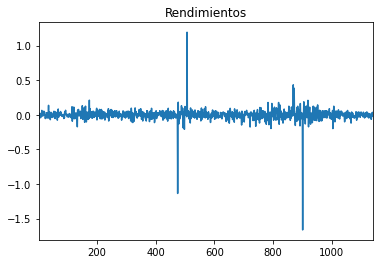

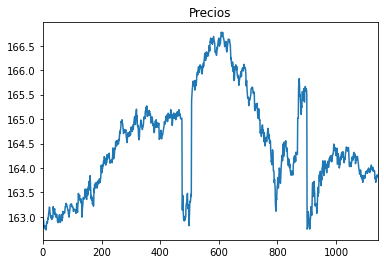

Slope: close    0.000566
dtype: float64
Min: 162.734, Max: 166.77599999999995
Plotting [38, 0, 22, 1, 5]


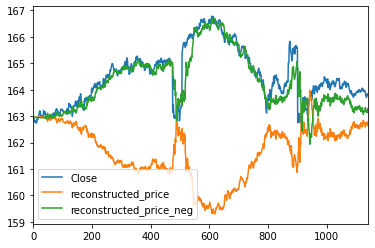

C:\Users\suare\data\list\whitelisted\sets\mdy20180911T1138.csv
C:\Users\suare\data\tmp\selection\spxl20180524T1550.csv
C:\Users\suare\data\tmp\selection\vv20171101T1523.csv


In [21]:
# for GLD
orders_df = pd.read_csv('C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\logs\\concated.csv', sep=';')
orders_df['orders'] = orders_df['orders'].apply(lambda x: x.split(','))
multiplier = 3

# superposed_list = [(40, 0, 1, 5, 4)]
superposed_list = [(38, 0, 22, 1, 5)]
superpose = True

for path in list(orders_df.FILEPATH.unique()):
    print(path)
    if 'iwo' in path:
        best_orders = list(orders_df[orders_df.FILEPATH==path].orders)
        print(best_orders)

        # 1. Load close prices
        fpattern = path
        df = pd.read_csv(fpattern, sep=',')
        returns = 100 * df['close'].pct_change().dropna()   # pct_change es para rendimientos
        returns.plot(title="Rendimientos")
        plt.show()
        prices = df['close'].dropna() 
        prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
        plt.show()
        slope = df[['close']].dropna().apply(lambda x: np.polyfit(df.index, x, 1)[0])
        # slopes.plot(title='Slope', label ='Time') 
        print(f'Slope: {slope}')
        data =  prices

        # 2. Standardize / convert to returns
        mode = 'returns'
        # train the standardization
        df = data.to_frame()
        min_max_scaler = MinMaxScaler()
        min_max_scaler = min_max_scaler.fit(df)
        print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 
        if mode=='returns':    
            TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True) #.dropna().reset_index(drop=True)
        else:     
            # standardization the dataset (don't use prices as these are auto correlated)
            TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
        TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)     

        if superpose:
            best_orders = superposed_list
            
        # 3 Iterate through best orders
        for (p_, n, q_, g_p, g_q) in best_orders:

            print(f'Plotting [{p_}, 0, {q_}, {g_p}, {g_q}]')
            try:
                # Initialize R GARCH model
                garch_spec = rugarch.ugarchspec(
                    # Using student T distribution usually provides better fit
                    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), 
                    # Using student T distribution usually provides better fit
                    variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
                    distribution_model='sged')  # 'std'

                # Used to convert training set to R list for model input
                numpy2ri.activate()
                forecast_horizon = 1

                # Train R GARCH model on returns as %
                garch_fitted = rugarch.ugarchfit(
                    spec=garch_spec,
                    data=np.array(TS),
                    out_sample=forecast_horizon
                )
                numpy2ri.deactivate()

            
                # print(garch_fitted)
                # print('Showing ARMA-GARCH coefficients:')
                # print(garch_fitted.slots['fit'].rx2('coef'))

                # Model's fitted standard deviation values
                fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
                minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                
                
#                 output = pd.DataFrame({
#                     'actual': list(np.array(TS)),
#                     'model': np.append(fitted*multiplier, forecast*multiplier),
#                 })

#                 plt.plot(output['actual'][:-forecast_horizon], label='Train')
#                 plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
#                 plt.plot(output['model'][:-forecast_horizon], label='Fitted')
#                 plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
#                 plt.legend()
#                 plt.show();

                # Forecast 
                garch_forecast = rugarch.ugarchforecast(
                    garch_fitted,
                    n_ahead=2,
                    n_roll=0, #forecast_horizon - 1
                )

                # Model's forecasted standard deviation values
                forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
                forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

                # how to reconstruct prices
                df = pd.DataFrame() 
                df['Close'] = data[:-forecast_horizon] # data
                fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                df['ts_logr_na0'] = TS
                df['logr_na0'] = fitted  # TS

                # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
                # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
                df['cuml_log']= np.cumsum(df.logr_na0 * multiplier) # 1
                df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
                df['cuml_log_negative']= np.cumsum(df.logr_na0 * -1 * multiplier) # 1
                df['reconstructed_price_norm_neg'] = np.exp(df.cuml_log_negative) # 2
                # multiplicamos todos los valores por dicho valor y listo.
                df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
                df['reconstructed_price_neg'] = df['Close'].values[0] * df.reconstructed_price_norm_neg
                df['reconstructed_price'] = df['reconstructed_price'].astype(float)
                df['reconstructed_price_neg'] = df['reconstructed_price_neg'].astype(float)
                # df

                # making sure that the model adaps well
                df[['Close','reconstructed_price', 'reconstructed_price_neg']].plot()
                fitted_reconstructed = df['reconstructed_price']
                plt.show();
                # df
            except:
                print('Error reconstructing prices')

C:\Users\suare\data\list\whitelisted\sets\biv20170210T1354.csv
C:\Users\suare\data\list\whitelisted\sets\iwm20171011T1854.csv
C:\Users\suare\data\list\whitelisted\sets\iwo20170607T1613.csv
[['1', '0', '15', '3', '2'], ['2', '0', '18', '1', '3'], ['3', '0', '16', '3', '1'], ['4', '0', '17', '4', '2'], ['5', '0', '13', '2', '2'], ['6', '0', '18', '2', '1'], ['7', '0', '18', '1', '2'], ['8', '0', '18', '2', '1'], ['9', '0', '7', '3', '2'], ['10', '0', '11', '2', '2'], ['11', '0', '5', '2', '3'], ['12', '0', '9', '2', '1'], ['13', '0', '16', '4', '1'], ['14', '0', '17', '3', '1'], ['15', '0', '16', '4', '1'], ['16', '0', '15', '1', '2'], ['17', '0', '28', '1', '3'], ['18', '0', '25', '1', '1'], ['19', '0', '13', '5', '2'], ['20', '0', '12', '5', '1'], ['21', '0', '15', '1', '1'], ['22', '0', '26', '1', '5'], ['23', '0', '24', '1', '1'], ['24', '0', '26', '1', '2'], ['25', '0', '16', '5', '2'], ['26', '0', '22', '1', '1'], ['27', '0', '17', '2', '1'], ['28', '0', '10', '1', '1'], ['29', '0'

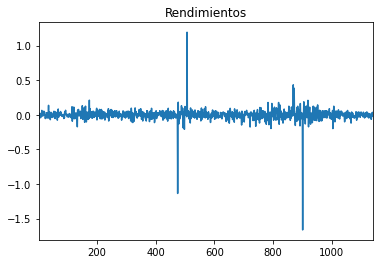

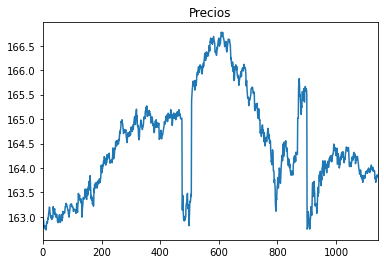

Slope: close    0.000566
dtype: float64
Min: 162.734, Max: 166.77599999999995
Plotting [31, 0, 15, 5, 1]


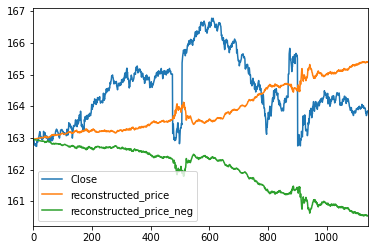

Plotting [32, 0, 28, 2, 1]
Error reconstructing prices
Plotting [33, 0, 28, 1, 1]


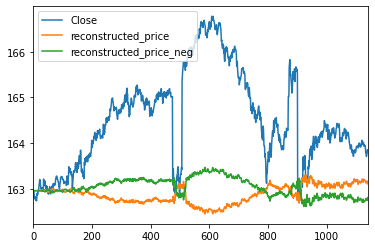

Plotting [34, 0, 23, 2, 5]


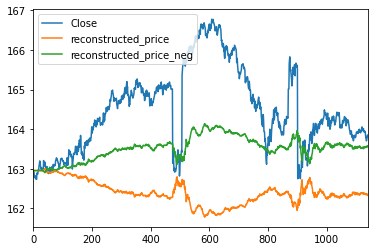

Plotting [35, 0, 23, 2, 2]
Error reconstructing prices
Plotting [36, 0, 19, 3, 3]


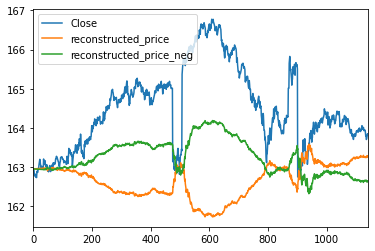

Plotting [37, 0, 22, 4, 1]
Error reconstructing prices
Plotting [38, 0, 22, 1, 5]


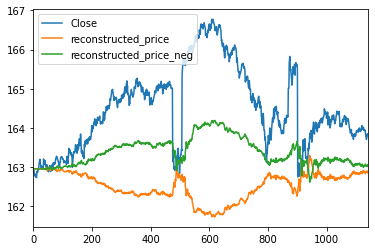

Plotting [39, 0, 20, 5, 1]
Error reconstructing prices
Plotting [40, 0, 14, 4, 1]
Error reconstructing prices
Plotting [41, 0, 24, 2, 5]


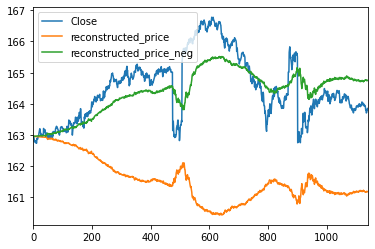

Plotting [42, 0, 25, 1, 2]


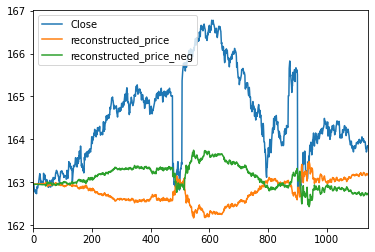

Plotting [43, 0, 23, 2, 5]


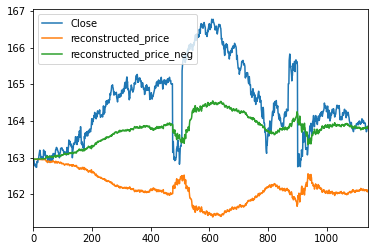

Plotting [44, 0, 24, 2, 1]
Error reconstructing prices
Plotting [45, 0, 15, 4, 1]


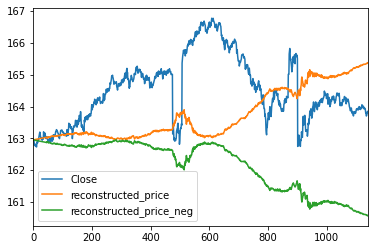

Plotting [46, 0, 29, 1, 2]


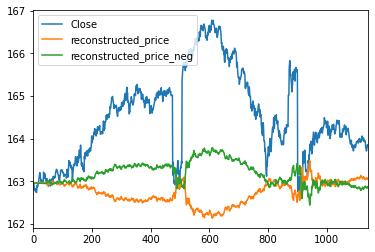

Plotting [47, 0, 18, 5, 1]
Error reconstructing prices
Plotting [48, 0, 26, 1, 5]


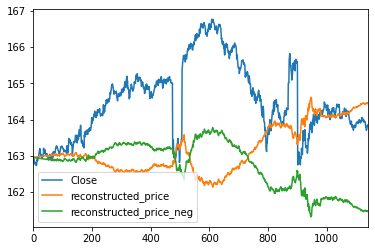

Plotting [49, 0, 13, 1, 1]
Error reconstructing prices
Plotting [50, 0, 29, 1, 5]
Error reconstructing prices
C:\Users\suare\data\list\whitelisted\sets\mdy20180911T1138.csv


In [14]:
# for GLD
orders_df = pd.read_csv('C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\logs\\concated.csv', sep=';')
orders_df['orders'] = orders_df['orders'].apply(lambda x: x.split(','))
multiplier = 5

for path in list(orders_df.FILEPATH.unique()):
    print(path)
    if 'iwo' in path:
        best_orders = list(orders_df[orders_df.FILEPATH==path].orders)
        print(best_orders)

        # 1. Load close prices
        fpattern = path
        df = pd.read_csv(fpattern, sep=',')
        returns = 100 * df['close'].pct_change().dropna()   # pct_change es para rendimientos
        returns.plot(title="Rendimientos")
        plt.show()
        prices = df['close'].dropna() 
        prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
        plt.show()
        slope = df[['close']].dropna().apply(lambda x: np.polyfit(df.index, x, 1)[0])
        # slopes.plot(title='Slope', label ='Time') 
        print(f'Slope: {slope}')
        data =  prices

        # 2. Standardize / convert to returns
        mode = 'returns'
        # train the standardization
        df = data.to_frame()
        min_max_scaler = MinMaxScaler()
        min_max_scaler = min_max_scaler.fit(df)
        print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 
        if mode=='returns':    
            TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True) #.dropna().reset_index(drop=True)
        else:     
            # standardization the dataset (don't use prices as these are auto correlated)
            TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
        TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)     

        # 3 Iterate through best orders
        for (p_, n, q_, g_p, g_q) in best_orders:
            if int(p_) > 30:
                print(f'Plotting [{p_}, 0, {q_}, {g_p}, {g_q}]')
                try:
                    # Initialize R GARCH model
                    garch_spec = rugarch.ugarchspec(
                        # Using student T distribution usually provides better fit
                        mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), 
                        # Using student T distribution usually provides better fit
                        variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
                        distribution_model='sged')  # 'std'

                    # Used to convert training set to R list for model input
                    numpy2ri.activate()
                    forecast_horizon = 1

                    # Train R GARCH model on returns as %
                    garch_fitted = rugarch.ugarchfit(
                        spec=garch_spec,
                        data=np.array(TS),
                        out_sample=forecast_horizon
                    )
                    numpy2ri.deactivate()

                    # print(garch_fitted)
                    # print('Showing ARMA-GARCH coefficients:')
                    # print(garch_fitted.slots['fit'].rx2('coef'))

                    # Model's fitted standard deviation values
                    fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
                    minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
                    fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

                    # Forecast 
                    garch_forecast = rugarch.ugarchforecast(
                        garch_fitted,
                        n_ahead=1,
                        n_roll=0, #forecast_horizon - 1
                    )

                    # Model's forecasted standard deviation values
                    forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
                    forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

                    # how to reconstruct prices
                    df = pd.DataFrame() 
                    df['Close'] = data[:-forecast_horizon] # data
                    fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
                    df['ts_logr_na0'] = TS
                    df['logr_na0'] = fitted  # TS

                    # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
                    # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
                    df['cuml_log']= np.cumsum(df.logr_na0 * 1) # 1
                    df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
                    df['cuml_log_negative']= np.cumsum(df.logr_na0 * -1) # 1
                    df['reconstructed_price_norm_neg'] = np.exp(df.cuml_log_negative) # 2
                    # multiplicamos todos los valores por dicho valor y listo.
                    df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
                    df['reconstructed_price_neg'] = df['Close'].values[0] * df.reconstructed_price_norm_neg
                    df['reconstructed_price'] = df['reconstructed_price'].astype(float)
                    df['reconstructed_price_neg'] = df['reconstructed_price_neg'].astype(float)
                    # df

                    # making sure that the model adaps well
                    df[['Close','reconstructed_price', 'reconstructed_price_neg']].plot()
                    fitted_reconstructed = df['reconstructed_price']
                    plt.show();
                except:
                    print('Error reconstructing prices')
                # df

## Old manual script

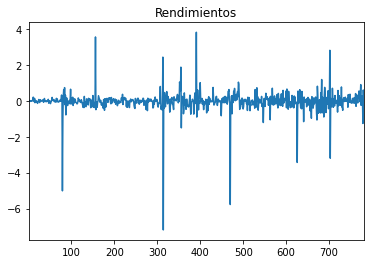

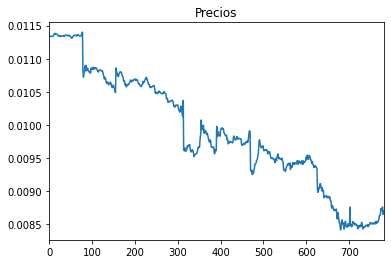

Slope: close   -0.000004
dtype: float64


In [32]:
# regex = '20170717'
# fpattern = f'C:\\Users\\suare\\MEGA\\PhD\\1 Code and data\\data\\raw\\quantquote\\one_second_level\\242321_csv\\{regex}\\spy.csv'

multiplier = -5

# path, multiplier = '..\\data\\aapl\\APPLE_[2018-08-20_to_2018-08-31]_5min.csv', multiplier
# path, multiplier = '..\\data\\aapl\\APPLE_[2018-08-01_to_2018-09-11]_5min.csv', multiplier
# path, multiplier = '..\\data\\efts\\5min-level\\DOWJONES\\DOWJONES_[2015-08-01_to_2015-08-31]_market_hours.csv', multiplier
# path, multiplier = '..\\data\\btc\\BITCOIN_[2019-07-01_to_2019-07-15]_5min.csv', multiplier
# path, multiplier = '..\\data\\xrp\\RIPPLE_[2019-06-01_to_2019-07-01]_5min.csv', multiplier
# path, multiplier = '..\\data\\efts\\30min-level\\IBEX\\IBEX_[2017-10-01_to_2017-31-12]_market_hours.csv', multiplier
# path, multiplier = '..\\data\\xrp\\RIPPLE_[2019-07-01_to_2019-08-01]_5min.csv', multiplier
# path, multiplier = '..\\data\\efts\\30min-level\\IBEX\\IBEX_[2017-10-01_to_2017-31-12]_market_hours.csv', multiplier
path, multiplier = '..\\data\\efts\\5min-level\\EMB\\EMB_[2020-03-06_to_2020-03-20]_market_hours.csv', multiplier
# path, multiplier = '..\\data\\efts\\5min-level\\GLD\\\GLD_[2018-09-01_to_2018-09-15]_market_hours.csv', multiplier
# path, multiplier = '..\\data\\efts\\5min-level\\XLE\\XLE_[2018-03-16_to_2018-04-01]_market_hours.csv', multiplier


fpattern = path
# colnames=['Time','Open','High','Low','Close','Volume','Suspicious']
sp500 = pd.read_csv(fpattern, sep=';')
# sp500 = pd.concat(list(pd.read_csv(f, names=colnames) for f in glob.glob(fpattern)), ignore_index=True)
# regex='DOWJONES_(2015-01-01_to_2015-12-31)_indicators.csv.gz'
# path=os.sep.join(['G:','My Drive','PhD_Andres','Datos','quantquote','processed_data','2_result','minutes','15min-level','DOWJONES'])
# fpattern = os.sep.join([path,regex])
# sp500 = pd.read_csv(fpattern, compression='gzip')

returns = 100 * sp500['close'].pct_change().dropna()   # pct_change es para rendimientos
returns.plot(title="Rendimientos")
plt.show()
prices = sp500['close'].dropna() 
prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
plt.show()

slope = sp500[['close']].dropna().apply(lambda x: np.polyfit(sp500.index, x, 1)[0])
# slopes.plot(title='Slope', label ='Time') 
print(f'Slope: {slope}')
data =  prices

In [40]:
sp500.head()

,datetime,open,high,low,close,gap,timestamp
0,2020-03-06 09:30:00,0.011333,0.011341,0.011332,0.011338,0.011338,1583487000
1,2020-03-06 09:35:00,0.011338,0.011340,0.011338,0.011340,0.011340,1583487300
2,2020-03-06 09:40:00,0.011338,0.011343,0.011338,0.011343,0.011343,1583487600
3,2020-03-06 09:45:00,0.011342,0.011343,0.011339,0.011339,0.011339,1583487900
4,2020-03-06 09:50:00,0.011343,0.011343,0.011337,0.011337,0.011337,1583488200


In [33]:
mode = 'returns'

# train the standardization
df = data.to_frame()
min_max_scaler = MinMaxScaler()
min_max_scaler = min_max_scaler.fit(df)
print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 

if mode=='returns':    
    TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True)#.dropna().reset_index(drop=True)
else:     
    # standardization the dataset
    TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)                                                                  


Min: 0.008414650000000001, Max: 0.011400200000000001


In [42]:
# # res_tup = (4, 0, 3) # _get_best_model(TS)  
# # res_tup = (8, 0, 8)
# # res_tup = (4, 0, 5)
# # res_tup = (2, 0, 5)
# # res_tup = (4, 0, 5)
# # res_tup = (8, 0, 6)
# # res_tup = (9, 0, 10)
# # RES_TUP = (7, 0, 8)
# res_tup = (9, 0, 9)
# res_tup = (7, 0, 10)

# # 8, 0, 8, 2, 3
# order = res_tup[1]
# model = res_tup[2]
# order

In [43]:
# tsplot(model.resid, lags=30)

In [44]:
# tsplot(model.resid**2, lags=30)

In [34]:
# Now we can fit the arch model using the best fit arima model parameters
p_, q_ = 3, 4 # 9, 9 # 7, 8 # 9, 10 # 8, 6 # 4, 5 # 2, 5 # 4, 5  # 8, 8 # 4, 3 # order[0], order[2]
p_, q_ = 7, 10 # 9, 9 # 7, 8 # 9, 10 # 8, 6 # 4, 5 # 2, 5 # 4, 5  # 8, 8 # 4, 3 # order[0], order[2]
p_, q_ = 4, 4 # 9, 9 # 7, 8 # 9, 10 # 8, 6 # 4, 5 # 2, 5 # 4, 5  # 8, 8 # 4, 3 # order[0], order[2]

# o_ = order[1]
g_p, g_q = 1, 1 # 3, 1 # 2, 1 # 1, 3 # 2, 4 # 1, 1 # 1, 4 #  1, 5  # 2, 3 # 1, 1
g_p, g_q = 2, 5 # 3, 1 # 2, 1 # 1, 3 # 2, 4 # 1, 1 # 1, 4 #  1, 5  # 2, 3 # 1, 1
g_p, g_q = 1, 1 # 3, 1 # 2, 1 # 1, 3 # 2, 4 # 1, 1 # 1, 4 #  1, 5  # 2, 3 # 1, 1


# Initialize R GARCH model
garch_spec = rugarch.ugarchspec(
    #mean_model=robjects.r(f'list(arimaOrder=c({p_},{o_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
    variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
    distribution_model='sged')  # 'std'

#If you have looked at the package vignette, you would have seen that package rugarch estimates ARFIMA(p,d,q) 
# model with 0<d<1. So it is not possible to set the integration order higher than one. 
# If you want to keep the value d fixed set fixed.pars=list(arfima=d). 
# For that naturally you need to set arfima=TRUE in the argument mean.model

print(garch_spec)



*---------------------------------*

*       GARCH Model Spec          *

*---------------------------------*



Conditional Variance Dynamics 	

------------------------------------

GARCH Model		: sGARCH(1,1)

Variance Targeting	: FALSE 



Conditional Mean Dynamics

------------------------------------

Mean Model		: ARFIMA(4,0,4)

Include Mean		: TRUE 

GARCH-in-Mean		: FALSE 



Conditional Distribution

------------------------------------

Distribution	:  sged 

Includes Skew	:  TRUE 

Includes Shape	:  TRUE 

Includes Lambda	:  FALSE 





Plotting [1, 0, 2, 2, 1]


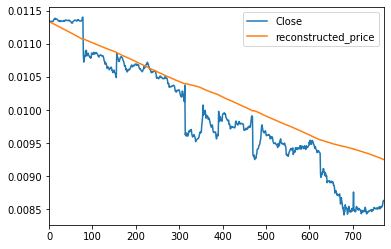

Plotting [2, 0, 3, 1, 1]


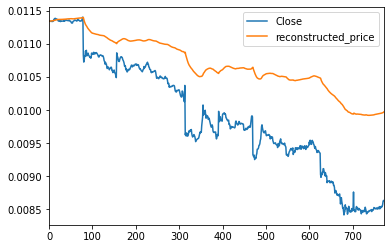

Plotting [3, 0, 4, 1, 1]


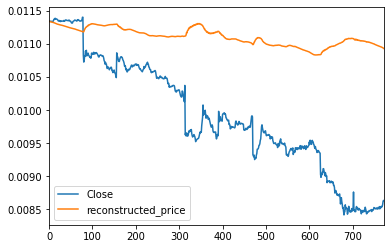

Plotting [4, 0, 4, 1, 1]


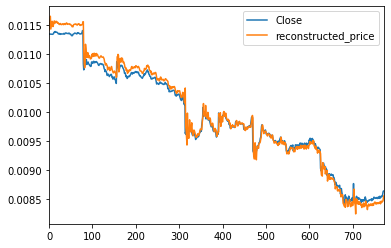

Plotting [5, 0, 7, 1, 1]


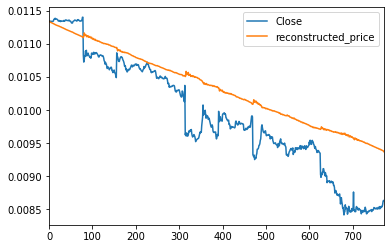

Plotting [7, 0, 7, 1, 1]


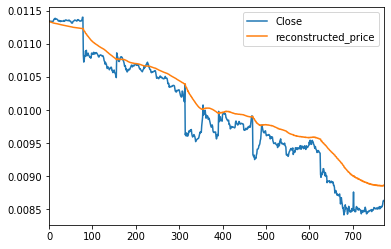

Plotting [8, 0, 8, 2, 1]


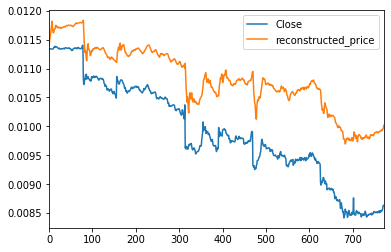

Plotting [9, 0, 9, 1, 1]


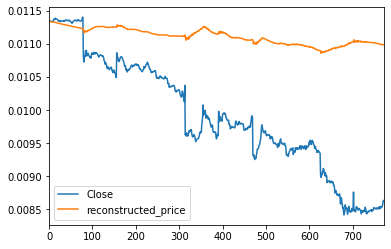

Plotting [10, 0, 9, 1, 1]


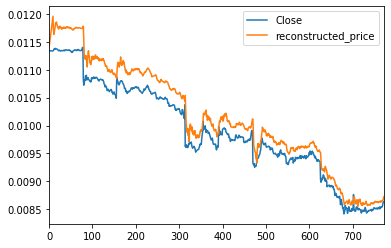

In [46]:
# for GLD
# best_orders=[(1, 0, 9, 1, 1) 
#              ,(2, 0, 6, 1, 1) 
#              ,(3, 0, 1, 1, 2)  
#              ,(4, 0, 2, 1, 1) 
#              ,(5, 0, 2, 1, 2) 
#              ,(6, 0, 4, 1, 2) 
#              ,(7, 0, 2, 1, 2)   
#              ,(8, 0, 2, 1, 1)   
#              ,(9, 0, 1, 1, 1)   
#              ,(10, 0, 1, 1, 2)]

# For XLE
# best_orders=[(1,0,5,2,4),(2,0,11,2,4),(3,0,12,2,4),(4,0,14,4,3),(5,0,12,2,4),(6,0,13,1,1),(7,0,10,2,5),(8,0,7,2,5),(9,0,20,4,4),(10,0,18,4,3),(11,0,12,2,5),(12,0,15,4,4),(13,0,13,4,1),(14,0,19,3,5),(15,0,17,4,4),(16,0,8,3,3),(17,0,20,2,5),(18,0,20,5,4),(19,0,19,1,2),(20,0,20,2,4)]

#  EMB
best_orders=[(1, 0, 2, 2, 1)
, (2, 0, 3, 1, 1)
, (3, 0, 4, 1, 1)
, (4, 0, 4, 1, 1)
, (5, 0, 7, 1, 1)
# , (6, 0, 8, 1, 1)
, (7, 0, 7, 1, 1)
, (8, 0, 8, 2, 1)
, (9, 0, 9, 1, 1)
,(10, 0, 9, 1, 1)]


# DJIA
#  = [[7, 0, 9, 2, 4]]
# best_orders=[(1,0,10,2,1)
# ,(2,0,8,2,1)
# ,(3,0,8,2,1)
# ,(4,0,8,2,1)
# ,(5,0,3,2,1)
# ,(6,0,7,2,1)
# ,(7,0,9,2,4)  # old best
# ,(8,0,8,2,3)
# ,(9,0,4,2,1)
# ,(10,0,5,2,1)]

# XRP JULY 2019
# best_orders = [[7, 0, 10, 2, 5]]
# best_orders=[
# (1,0,2,1,5),
# (2,0,2,1,5),
# (3,0,9,1,5),
# (4,0,5,2,4),
# (5,0,7,1,5), 
# (6,0,5,1,5),
# (7,0,8,1,5),
# (8,0,8,3,5),
# best_orders=[(9,0,10,1,3)] # old best
# (10,0,9,1,2)]

# AAPL
# best_orders = [(1,0,3,1,1),
# (2,0,3,1,1),
# (3,0,4,3,1),
# (4,0,3,1,1), # OLD BEST
# (5,0,6,1,1),
# (6,0,7,4,5),
# (7,0,8,1,1),
# (8,0,6,3,1), 
# (9,0,5,5,2),
# (10,0,6,4,1)],
# best_orders = [(1,0,3,1,1),(2,0,3,1,1),(3,0,4,3,1),(4,0,3,1,1),(5,0,6,1,1),(6,0,7,4,5),(7,0,8,1,1  ),(8,0,6,3,1),(9,0,15,1,3),(10,0,16,5,2),(11,0,18,1,3),(12,0,20,5,5),(13,0,14,1,2),(14,0,17,3,4),(15,0,16,1,2),(16,0,16,2,4),(17,0,17,3,5),(18,0,19,3,5),(19,0,18,3,4),(20,0,20,3,4)]

# APPL AUG 20-31
# best_orders = [(1, 0, 6, 5, 3),(2, 0, 2, 1, 3),(3, 0, 3, 1, 2),(4, 0, 5, 4, 1),(5, 0, 3, 2, 4),(6, 0, 4, 3, 4),(7, 0, 10, 3, 4),(8, 0, 6, 3, 1),(9, 0, 4, 1, 5),(10, 0, 6, 2, 1),
#                (14, 0, 14, 1, 5),(15, 0, 14, 4, 3),(16, 0, 8, 1, 4),(17, 0, 14, 2, 3),(18, 0, 20, 1, 4),(19, 0, 15, 2, 1),(20, 0, 20, 3, 3)]

for (p_, n, q_, g_p, g_q) in best_orders:

    print(f'Plotting [{p_}, 0, {q_}, {g_p}, {g_q}]')
    
    # Initialize R GARCH model
    garch_spec = rugarch.ugarchspec(
        #mean_model=robjects.r(f'list(arimaOrder=c({p_},{o_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
        mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
        variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
        distribution_model='sged')  # 'std'

    #If you have looked at the package vignette, you would have seen that package rugarch estimates ARFIMA(p,d,q) 
    # model with 0<d<1. So it is not possible to set the integration order higher than one. 
    # If you want to keep the value d fixed set fixed.pars=list(arfima=d). 
    # For that naturally you need to set arfima=TRUE in the argument mean.model

#     print(garch_spec)
    
    # Used to convert training set to R list for model input
    numpy2ri.activate()
    forecast_horizon = 9

    # Train R GARCH model on returns as %
    garch_fitted = rugarch.ugarchfit(
        spec=garch_spec,
        data=np.array(TS),
        out_sample=forecast_horizon
    )
    numpy2ri.deactivate()
    
#     print(garch_fitted)
#     print('Showing ARMA-GARCH coefficients:')
#     print(garch_fitted.slots['fit'].rx2('coef'))

    # Model's fitted standard deviation values
    fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
    minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
    fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

    # Forecast 
    garch_forecast = rugarch.ugarchforecast(
        garch_fitted,
        n_ahead=5,
        n_roll=0, #forecast_horizon - 1
    )

    # Model's forecasted standard deviation values
    forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
    forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()
    
    # how to reconstruct prices
    df = pd.DataFrame() 
    df['Close'] = data[:-forecast_horizon] # data
    fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
    df['ts_logr_na0'] = TS
    df['logr_na0'] = fitted  # TS

    # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
    # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
#     df['cuml_log']= np.cumsum(df.logr_na0 * -1) # 1
    df['cuml_log']= np.cumsum(df.logr_na0 * 1) # 1
    df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
    # multiplicamos todos los valores por dicho valor y listo.
    df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
    df['reconstructed_price'] = df['reconstructed_price'].astype(float)
    # df

    # making sure that the model adaps well
    df[['Close','reconstructed_price']].plot()
    fitted_reconstructed = df['reconstructed_price']
    plt.show();
    # df

Plotting [1, 0, 6, 5, 3]


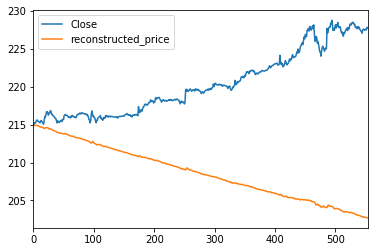

Plotting [2, 0, 2, 1, 3]


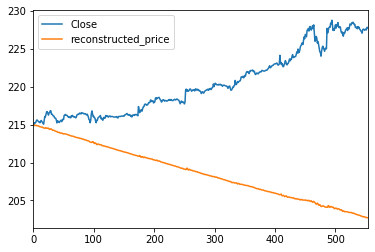

Plotting [3, 0, 3, 1, 2]


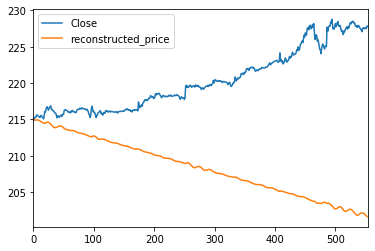

Plotting [4, 0, 5, 4, 1]


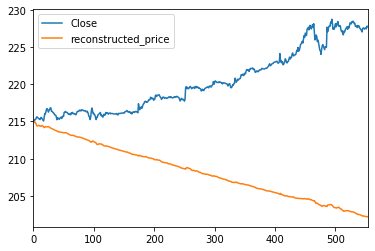

Plotting [5, 0, 3, 2, 4]


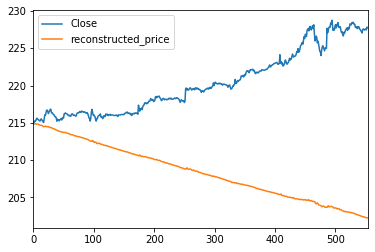

Plotting [6, 0, 4, 3, 4]


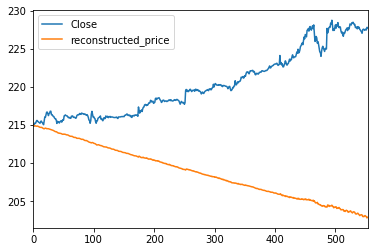

Plotting [7, 0, 10, 3, 4]


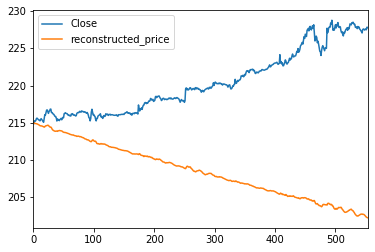

Plotting [8, 0, 6, 3, 1]


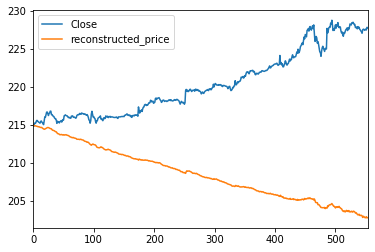

Plotting [9, 0, 4, 1, 5]


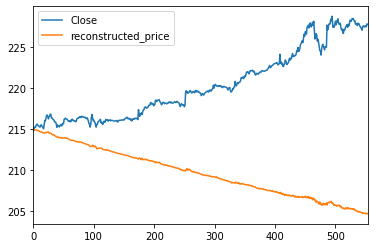

Plotting [10, 0, 6, 2, 1]


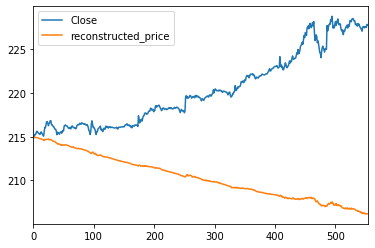

Plotting [14, 0, 14, 1, 5]


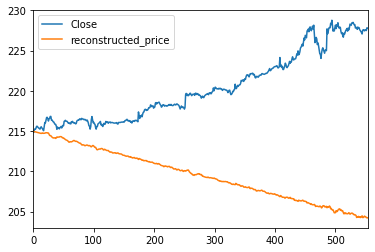

Plotting [15, 0, 14, 4, 3]


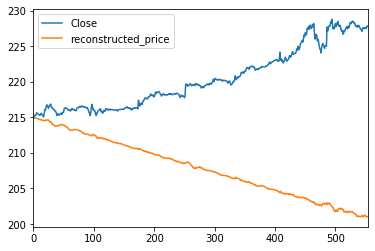

Plotting [16, 0, 8, 1, 4]


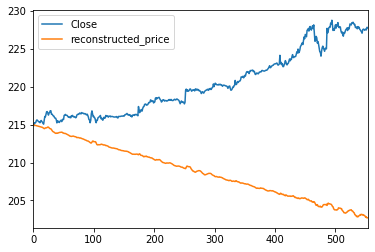

Plotting [17, 0, 14, 2, 3]


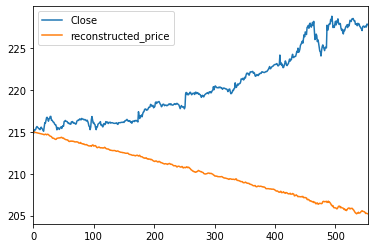

Plotting [18, 0, 20, 1, 4]


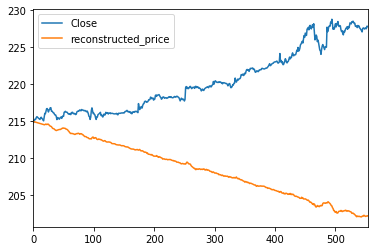

Plotting [19, 0, 15, 2, 1]


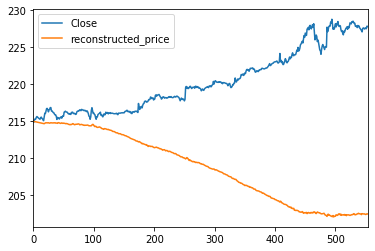

Plotting [20, 0, 20, 3, 3]


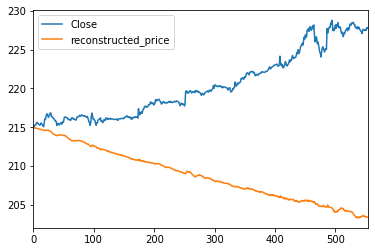

In [15]:
for (p_, n, q_, g_p, g_q) in best_orders:

    print(f'Plotting [{p_}, 0, {q_}, {g_p}, {g_q}]')
    
    # Initialize R GARCH model
    garch_spec = rugarch.ugarchspec(
        #mean_model=robjects.r(f'list(arimaOrder=c({p_},{o_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
        mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
        variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
        distribution_model='sged')  # 'std'

    #If you have looked at the package vignette, you would have seen that package rugarch estimates ARFIMA(p,d,q) 
    # model with 0<d<1. So it is not possible to set the integration order higher than one. 
    # If you want to keep the value d fixed set fixed.pars=list(arfima=d). 
    # For that naturally you need to set arfima=TRUE in the argument mean.model

#     print(garch_spec)
    
    # Used to convert training set to R list for model input
    numpy2ri.activate()
    forecast_horizon = 9

    # Train R GARCH model on returns as %
    garch_fitted = rugarch.ugarchfit(
        spec=garch_spec,
        data=np.array(TS),
        out_sample=forecast_horizon
    )
    numpy2ri.deactivate()
    
#     print(garch_fitted)
#     print('Showing ARMA-GARCH coefficients:')
#     print(garch_fitted.slots['fit'].rx2('coef'))

    # Model's fitted standard deviation values
    fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
    minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
    fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

    # Forecast 
    garch_forecast = rugarch.ugarchforecast(
        garch_fitted,
        n_ahead=6,
        n_roll=0, #forecast_horizon - 1
    )

    # Model's forecasted standard deviation values
    forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
    forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()
    
    # how to reconstruct prices
    df = pd.DataFrame() 
    df['Close'] = data[:-forecast_horizon] # data
    fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
    df['ts_logr_na0'] = TS
    df['logr_na0'] = fitted  # TS

    # aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
    # esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
    df['cuml_log']= np.cumsum(df.logr_na0 * -1) # 1
#     df['cuml_log']= np.cumsum(df.logr_na0 * 1) # 1
    df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
    # multiplicamos todos los valores por dicho valor y listo.
    df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
    df['reconstructed_price'] = df['reconstructed_price'].astype(float)
    # df

    # making sure that the model adaps well
    df[['Close','reconstructed_price']].plot()
    fitted_reconstructed = df['reconstructed_price']
    plt.show();
    # df

In [5]:
orders_df = pd.read_csv('C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\logs\\concated.csv', sep=';')
orders_df.head()

,model,p,orders,AIC,BIC,SIC,HQIC,FILEPATH
0,1,1,"(1,0,1,4,3)",NaN,NaN,NaN,NaN,'C:\\Users\\suare\\data\\list\\whitelisted\\se...
1,1,2,"(2,0,7,1,4)",NaN,NaN,NaN,NaN,'C:\\Users\\suare\\data\\list\\whitelisted\\se...
2,1,3,"(3,0,5,2,4)",NaN,NaN,NaN,NaN,'C:\\Users\\suare\\data\\list\\whitelisted\\se...
3,1,4,"(4,0,6,1,3)",NaN,NaN,NaN,NaN,'C:\\Users\\suare\\data\\list\\whitelisted\\se...
4,1,5,"(5,0,16,1,3)",NaN,NaN,NaN,NaN,'C:\\Users\\suare\\data\\list\\whitelisted\\se...


In [9]:
for path in list(orders_df.FILEPATH.unique()):
    print(path)
    best_orders = list(orders_df[orders_df.FILEPATH==path].orders)
    print(best_orders)

'C:\\Users\\suare\\data\\list\\whitelisted\\sets\\biv20170210T1354.csv'
['(1,0,1,4,3)', '(2,0,7,1,4)', '(3,0,5,2,4)', '(4,0,6,1,3)', '(5,0,16,1,3)', '(6,0,3,2,2)', '(7,0,3,4,1)', '(8,0,10,2,3)', '(9,0,16,2,2)', '(10,0,11,1,3)', '(11,0,17,1,3)', '(12,0,9,4,1)', '(13,0,16,1,3)', '(14,0,15,1,1)', '(15,0,13,3,2)', '(16,0,10,1,2)', '(17, 0, 11,1,1)', '(18, 0,8,1,1)']
'C:\\Users\\suare\\data\\list\\whitelisted\\sets\\iwm20171011T1854.csv'
['(1,0,1,1,2)', '(2,0,1,2,3)', '(3,0,2,3,4)', '(4,0,3,4,4)', '(5,0,1,3,1)', '(6,0,7,3,1)', '(7,0,1,1,1)', '(8,0,1,2,1)', '(9,0,1,2,1)', '(10,0,1,1,1)', '(11,0,10,2,1)', '(12,0,16,2,1)', '(13,0,6,2,1)', '(14,0,2,1,1)', '(15,0,9,1,1)', '(16,0,1,1,1)', '(17,0,1,2,1)', '(18,0,1,2,4)']
'C:\\Users\\suare\\data\\list\\whitelisted\\sets\\iwo20170607T1613.csv'
['(1,0,15,3,2)', '(2,0,18,1,3)', '(3,0,16,3,1)', '(4,0,17,4,2)', '(5,0,13,2,2)', '(6,0,18,2,1)', '(7,0,18,1,2)', '(8,0,18,2,1)', '(9,0,7,3,2)', '(10,0,11,2,2)', '(11,0,5,2,3)', '(12,0,9,2,1)', '(13,0,16,4,1)',

In [35]:
# Used to convert training set to R list for model input
numpy2ri.activate()
forecast_horizon = 9

# Train R GARCH model on returns as %
garch_fitted = rugarch.ugarchfit(
    spec=garch_spec,
    data=np.array(TS),
    out_sample=forecast_horizon
)
numpy2ri.deactivate()

In [114]:
type(garch_fitted)

rpy2.robjects.methods.RS4

In [37]:
print('Showing ARMA-GARCH coefficients:')
print(garch_fitted.slots['fit'].rx2('coef'))

Showing ARMA-GARCH coefficients:
          mu          ar1          ar2          ar3          ar4          ma1 

6.730496e-03 3.837098e-02 2.162895e-01 2.555477e-01 5.085530e-01 9.036934e-01 

         ma2          ma3          ma4        omega       alpha1        beta1 

7.835413e-01 7.213933e-01 4.304665e-01 3.198597e-08 5.001236e-02 9.000117e-01 

        skew        shape 

1.000157e+00 1.996459e+00 



In [103]:
# Model's fitted standard deviation values
fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

# Forecast 
garch_forecast = rugarch.ugarchforecast(
    garch_fitted,
    n_ahead=6,
    n_roll=0, #forecast_horizon - 1
)

garch_simulation = rugarch.ugarchsim(garch_fitted,
                                     n_sim=6,
                                     m_sim=1, prereturns=[1,1,1,1,1,1,1,1]) # ts[-roll:] if len(ts) > roll else ts)

# Model's forecasted standard deviation values
forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()
simulation_minute_volatility = np.array(garch_simulation.slots['simulation'].rx2('sigmaSim')).flatten()
simulation = np.array(garch_simulation.slots['simulation'].rx2('seriesSim')).flatten()

In [110]:
garch_fitted

R object with classes: ('uGARCHfit',) mapped to:
<RS4 - Python:0x000002252DC01C88 / R:0x00000225246EEFF8>

In [109]:
rugarch

rpy2.robjects.packages.Package as a <module 'rugarch'>

In [104]:
forecasted_minute_volatility

array([0.00248065, 0.00242448, 0.00236988, 0.00231681, 0.00226525,
       0.00221515])

In [105]:
simulation_minute_volatility

array([0.00077976, 0.00076111, 0.0007466 , 0.0007328 , 0.00071983,
       0.00071376])

In [106]:
forecast

array([ 0.00057102, -0.00092454, -0.00351158, -0.00230819, -0.00092023,
       -0.00202837])

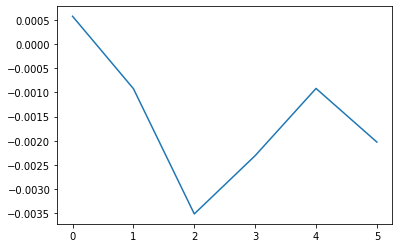

In [107]:
plt.plot(forecast)
plt.show()

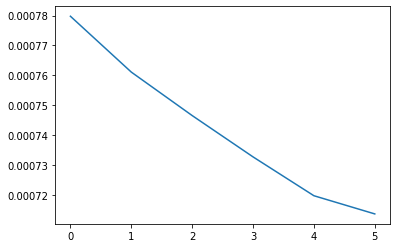

In [108]:
plt.plot(simulation_minute_volatility)
plt.show()

In [ ]:
# Model's fitted standard deviation values
fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

# Forecast 
garch_forecast = rugarch.ugarchforecast(
    garch_fitted,
    n_ahead=6,
    n_roll=0, #forecast_horizon - 1
)

# Model's forecasted standard deviation values
forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [390]:
# TESTING STUFF 18-09-2019

# print(garch_fitted.slots['fit'].rx2('coef'))
# rugarch.setfixed=(rugarch.getspec(garch_fitted), garch_fitted.slots['fit'].rx2('coef'))

# # Forecast 
# garch_f1 = rugarch.ugarchforecast(
#     spec=rugarch.getspec(garch_fitted),
#     n_ahead=1,
#     n_roll=forecast_horizon - 1
# )

# # Model's forecasted standard deviation values
# forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
# forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [391]:
## http://www.unstarched.net/r-examples/rugarch/a-short-introduction-to-the-rugarch-package/
# numpy2ri.activate()
# filt1 = rugarch.ugarchfilter(spec=rugarch.getspec(garch_fitted), data=np.array(TS), n_old = len(TS))
# numpy2ri.deactivate()

# filt1 = ugarchfilter(spec, sp500ret[1:1200, ], n.old = 1000)
# filt2 = ugarchfilter(spec, sp500ret[1001:1200, ])
# then forecast


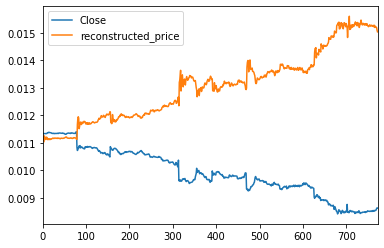

In [392]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted  # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0 * -1) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(float)
# df

# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
fitted_reconstructed = df['reconstructed_price']
# df

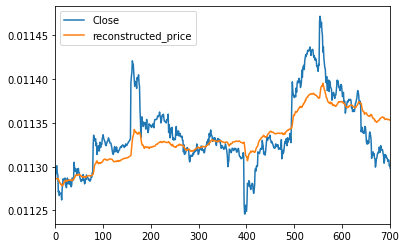

In [273]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted  # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0 * -1) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(float)
# df

# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
fitted_reconstructed = df['reconstructed_price']
# df

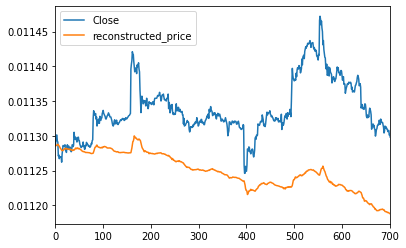

In [295]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted  # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0 * -1) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(float)
# df

# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
fitted_reconstructed = df['reconstructed_price']
# df

In [393]:
# Model's fitted standard deviation values
fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

# Forecast 
garch_forecast = rugarch.ugarchforecast(
    garch_fitted,
    n_ahead=1,
    n_roll=forecast_horizon - 1
)

# Model's forecasted standard deviation values
forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [394]:
np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()

array([0.00935191, 0.00935191, 0.00935191, 0.00935191, 0.00901344,
       0.00955258, 0.00911065, 0.00867151, 0.00828931, 0.00787055,
       0.00762105, 0.00724604, 0.00687671, 0.00656672, 0.00623419,
       0.00597369, 0.00572221, 0.00543779, 0.0051725 , 0.00491439,
       0.00467134, 0.00444501, 0.00422259, 0.00401172, 0.00382038,
       0.00363474, 0.00346952, 0.00330872, 0.00316071, 0.00301336,
       0.00286502, 0.00272985, 0.00259837, 0.00247881, 0.00236355,
       0.00225015, 0.00218558, 0.00208219, 0.00204336, 0.00195125,
       0.00186048, 0.00180116, 0.00171902, 0.00168886, 0.00161227,
       0.00154227, 0.0014756 , 0.0014254 , 0.00139901, 0.0013595 ,
       0.00130902, 0.00125547, 0.0012105 , 0.00116378, 0.00117047,
       0.00112479, 0.0012013 , 0.00124961, 0.00120095, 0.00115328,
       0.00111363, 0.00107161, 0.00103869, 0.00101043, 0.00097986,
       0.00094856, 0.00099704, 0.00104154, 0.00102479, 0.00102091,
       0.00098691, 0.00096791, 0.00094648, 0.00096739, 0.00094

In [395]:
tuple(garch_fitted.slotnames())

('fit', 'model')

In [396]:
import rpy2.robjects as robjects

get_infocrit = robjects.r('''function(fitted) {
                                return(infocriteria(fitted))
                             }''')

get_coef = robjects.r('''function(fitted) {
                                return(coef(fitted))
                             }''')


In [397]:
print(get_infocrit(garch_fitted))

                      

Akaike       -3.838530

Bayes        -3.754308

Shibata      -3.839171

Hannan-Quinn -3.806123



In [398]:
get_infocrit(garch_fitted)

-3.838530,-3.754308,-3.839171,-3.806123


In [399]:
tuple(garch_fitted.slots['fit'].names)

('hessian',
 'cvar',
 'var',
 'sigma',
 'condH',
 'z',
 'LLH',
 'log.likelihoods',
 'residuals',
 'coef',
 'robust.cvar',
 'A',
 'B',
 'scores',
 'se.coef',
 'tval',
 'matcoef',
 'robust.se.coef',
 'robust.tval',
 'robust.matcoef',
 'fitted.values',
 'convergence',
 'kappa',
 'persistence',
 'timer',
 'ipars',
 'solver')

In [400]:
print(garch_fitted.slots['fit'].rx2('coef'))  # this gives a vector of coefficients [mu, ar1, ar2, ar3, ar4, ma1, ma2, ma3, omega, alpha1, beta1. skw, shape]
coef = garch_fitted.slots['fit'].rx2('coef') 

          mu          ar1          ar2          ar3          ar4          ma1 

6.730496e-03 3.837098e-02 2.162895e-01 2.555477e-01 5.085530e-01 9.036934e-01 

         ma2          ma3          ma4        omega       alpha1        beta1 

7.835413e-01 7.213933e-01 4.304665e-01 3.198597e-08 5.001236e-02 9.000117e-01 

        skew        shape 

1.000157e+00 1.996459e+00 



In [401]:
omega = coef[-5]
alpha = coef[-4]
beta = coef[-3]

In [402]:
alpha

0.05001236171232727

In [403]:
print(get_coef(garch_fitted))

          mu          ar1          ar2          ar3          ar4          ma1 

6.730496e-03 3.837098e-02 2.162895e-01 2.555477e-01 5.085530e-01 9.036934e-01 

         ma2          ma3          ma4        omega       alpha1        beta1 

7.835413e-01 7.213933e-01 4.304665e-01 3.198597e-08 5.001236e-02 9.000117e-01 

        skew        shape 

1.000157e+00 1.996459e+00 



In [404]:
tuple(garch_fitted.slots['model'].names)

('modelinc',
 'modeldesc',
 'modeldata',
 'pars',
 'start.pars',
 'fixed.pars',
 'maxOrder',
 'pos.matrix',
 'fmodel',
 'pidx',
 'n.start')

In [405]:
rugarch.getspec(garch_fitted).slots

In [406]:
rugarch.ugarchspec()

R object with classes: ('uGARCHspec',) mapped to:
<RS4 - Python:0x000001CE0FA18848 / R:0x000001CE1A46FDE8>

In [407]:
print(rugarch.getspec(garch_fitted))



*---------------------------------*

*       GARCH Model Spec          *

*---------------------------------*



Conditional Variance Dynamics 	

------------------------------------

GARCH Model		: sGARCH(1,1)

Variance Targeting	: FALSE 



Conditional Mean Dynamics

------------------------------------

Mean Model		: ARFIMA(4,0,4)

Include Mean		: TRUE 

GARCH-in-Mean		: FALSE 



Conditional Distribution

------------------------------------

Distribution	:  sged 

Includes Skew	:  TRUE 

Includes Shape	:  TRUE 

Includes Lambda	:  FALSE 





In [408]:
# # Forecast 
# garch_forecast = rugarch.ugarchforecast(spec=garch_spec,
#     data=
#     n_ahead=1,
#     n_roll=forecast_horizon - 1
# )

# # Model's forecasted standard deviation values
# forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
# forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [409]:
garch_fitted.slots['fit'].rx2('coef')

0.006730,0.038371,0.216290,0.255548,...,0.050012,0.900012,1.000157,1.996459


In [410]:
rugarch.getspec(garch_fitted)

R object with classes: ('uGARCHspec',) mapped to:
<RS4 - Python:0x000001CE0FA12F08 / R:0x000001CE1A120058>

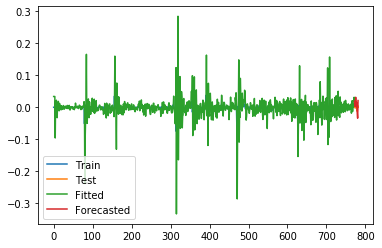

In [411]:
multiplier = 5

output = pd.DataFrame({
    'actual': list(np.array(TS)),
    'model': np.append(fitted*multiplier, forecast*multiplier),
})

plt.plot(output['actual'][:-forecast_horizon], label='Train')
plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
plt.plot(output['model'][:-forecast_horizon], label='Fitted')
plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
plt.legend()
plt.show()

In [375]:
multiplier = 5

output = pd.DataFrame({
    'actual': list(np.array(TS)),
    'model': np.append(fitted*multiplier, forecast*multiplier),
})

plt.plot(output['actual'][:-forecast_horizon], label='Train')
plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
plt.plot(output['model'][:-forecast_horizon], label='Fitted')
plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
plt.legend()
plt.show()

ValueError: arrays must all be same length

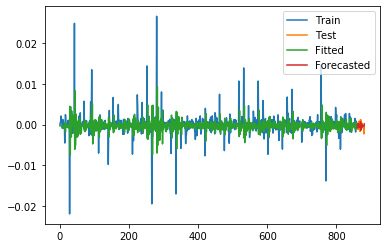

In [66]:
multiplier = 5

output = pd.DataFrame({
    'actual': list(np.array(TS)),
    'model': np.append(fitted*multiplier, forecast*multiplier),
})

plt.plot(output['actual'][:-forecast_horizon], label='Train')
plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
plt.plot(output['model'][:-forecast_horizon], label='Fitted')
plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
plt.legend()
plt.show()

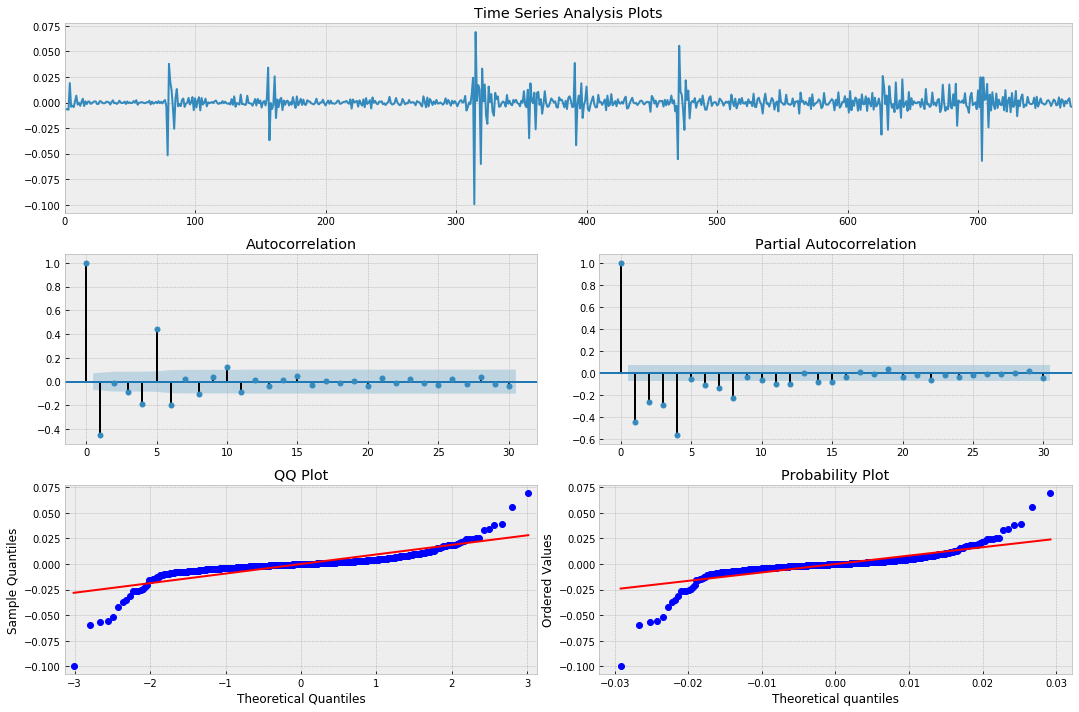

In [372]:
tsplot(minute_volatility_residuals, lags=30)

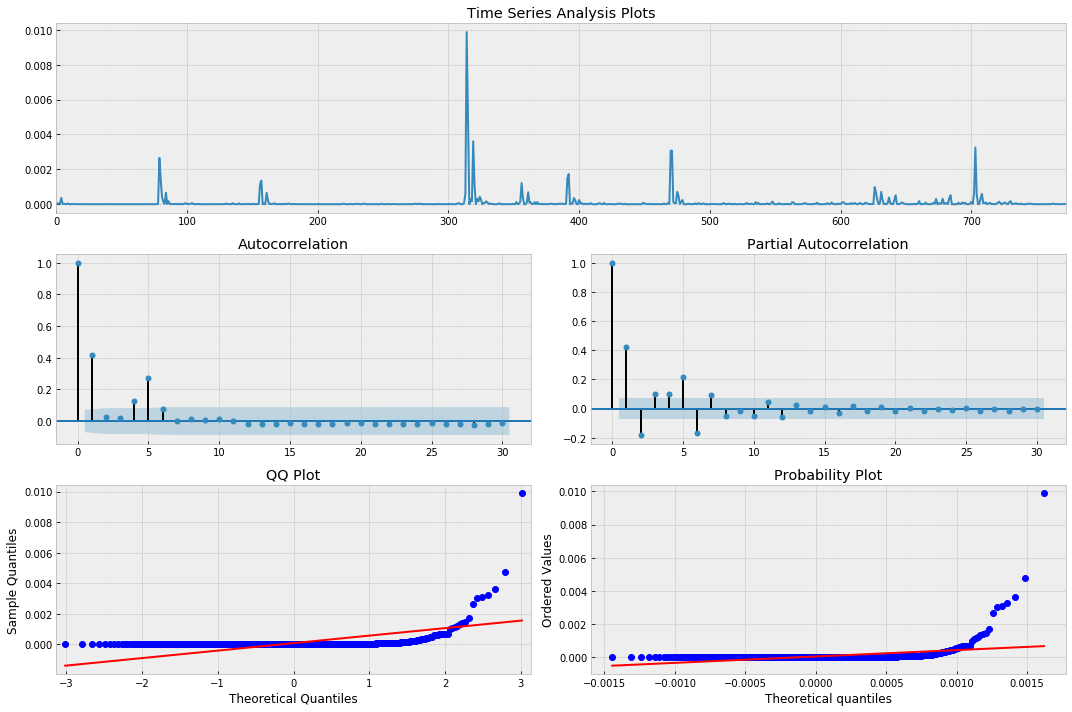

In [373]:
tsplot(minute_volatility_residuals**2, lags=30)

,Close,ts_logr_na0,logr_na0,cuml_log,reconstructed_price_norm,reconstructed_price
0,0.011338,0.000000,0.006730,0.006730,1.006753,0.011415
1,0.011340,0.000132,0.006730,0.013461,1.013552,0.011492
2,0.011343,0.000256,0.006730,0.020191,1.020397,0.011570
3,0.011339,-0.000335,0.006730,0.026922,1.027288,0.011648
4,0.011337,-0.000141,-0.019166,0.007756,1.007787,0.011427
5,0.011337,-0.000035,0.004073,0.011830,1.011900,0.011473
6,0.011339,0.000168,0.003195,0.015025,1.015139,0.011510
7,0.011338,-0.000088,0.004393,0.019418,1.019608,0.011561
8,0.011336,-0.000176,-0.001371,0.018047,1.018211,0.011545
9,0.011339,0.000265,-0.006512,0.011535,1.011602,0.011470


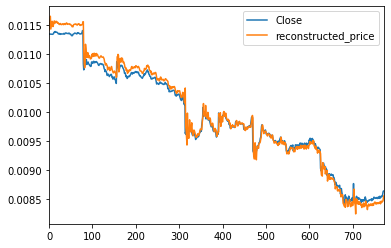

In [374]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted  # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(float)
df

# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
fitted_reconstructed = df['reconstructed_price']
df

,Close,ts_logr_na0,logr_na0,cuml_log,reconstructed_price_norm,reconstructed_price
0,0.011286,0.000000,1.884772e-06,0.000002,1.000002,0.011286
1,0.011295,0.000797,1.884772e-06,0.000004,1.000004,0.011286
2,0.011301,0.000531,1.884772e-06,0.000006,1.000006,0.011286
3,0.011301,0.000000,1.884772e-06,0.000008,1.000008,0.011286
4,0.011292,-0.000797,1.884772e-06,0.000009,1.000009,0.011286
5,0.011291,-0.000089,1.884772e-06,0.000011,1.000011,0.011286
6,0.011271,-0.001773,-9.497309e-06,0.000002,1.000002,0.011286
7,0.011272,0.000133,1.025828e-04,0.000104,1.000104,0.011287
8,0.011267,-0.000488,3.267108e-05,0.000137,1.000137,0.011288
9,0.011270,0.000266,1.361604e-04,0.000273,1.000273,0.011289


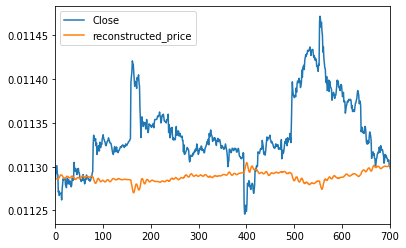

In [191]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted  # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(float)
df

# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
fitted_reconstructed = df['reconstructed_price']
df

,Close,ts_logr_na0,logr_na0,cuml_log,reconstructed_price_norm,reconstructed_price
0,0.011286,0.000000,1.884772e-06,0.000002,1.000002,0.011286
1,0.011295,0.000797,1.884772e-06,0.000004,1.000004,0.011286
2,0.011301,0.000531,1.884772e-06,0.000006,1.000006,0.011286
3,0.011301,0.000000,1.884772e-06,0.000008,1.000008,0.011286
4,0.011292,-0.000797,1.884772e-06,0.000009,1.000009,0.011286
5,0.011291,-0.000089,1.884772e-06,0.000011,1.000011,0.011286
6,0.011271,-0.001773,-9.497309e-06,0.000002,1.000002,0.011286
7,0.011272,0.000133,1.025828e-04,0.000104,1.000104,0.011287
8,0.011267,-0.000488,3.267108e-05,0.000137,1.000137,0.011288
9,0.011270,0.000266,1.361604e-04,0.000273,1.000273,0.011289


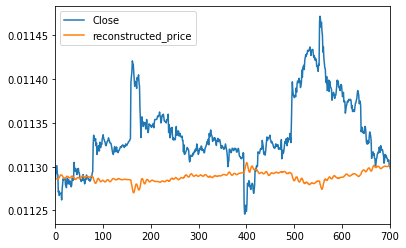

In [193]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted  # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(float)
df

# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
fitted_reconstructed = df['reconstructed_price']
df

In [82]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0 * multiplier) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(int)
df

# making sure that the model adaps well
fitted_reconstructed = df['reconstructed_price']
df.head()

,Close,ts_logr_na0,logr_na0,cuml_log,reconstructed_price_norm,reconstructed_price
0,0.011338,0.000000,-0.000132,-0.000659,0.999341,0
1,0.011340,0.000132,-0.000132,-0.001319,0.998682,0
2,0.011343,0.000256,-0.000132,-0.001978,0.998024,0
3,0.011339,-0.000335,-0.000153,-0.002746,0.997258,0
4,0.011337,-0.000141,-0.000148,-0.003485,0.996521,0


In [83]:
init_val = df['Close'].values[0]

In [84]:
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()


In [85]:
# multiplicamos todos los valores por dicho valor y listo.
init_val * np.exp(np.cumsum(forecast * -1))
# making sure that the model adaps well
df.head()

,Close,ts_logr_na0,logr_na0,cuml_log,reconstructed_price_norm,reconstructed_price
0,0.011338,0.000000,-0.000132,-0.000659,0.999341,0
1,0.011340,0.000132,-0.000132,-0.001319,0.998682,0
2,0.011343,0.000256,-0.000132,-0.001978,0.998024,0
3,0.011339,-0.000335,-0.000153,-0.002746,0.997258,0
4,0.011337,-0.000141,-0.000148,-0.003485,0.996521,0


C:\Users\suare\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1001: UserWarning: Attempting to set identical left == right == 773.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


,Close,logr_na0,reconstructed_price_norm,reconstructed_price
773,0.008657,-0.000624,1.000624,0


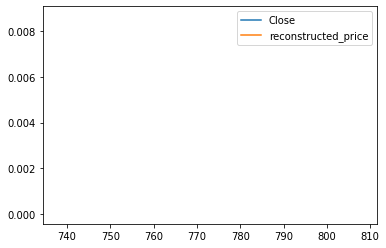

In [86]:
# reconstructing forecasting
df = pd.DataFrame() 
df['Close'] = data[-(forecast_horizon):-(forecast_horizon)+1] # data
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()
df['logr_na0'] = forecast[0] 
df['reconstructed_price_norm'] = np.exp(df.logr_na0 * -1) #
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(int)
# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
df.head()

In [87]:
# reconstructing forecasting
reconstructed_price = int(df['Close'].values[0] * np.exp(forecast[0] * -1))
print(f'orig: {data[-(forecast_horizon):-(forecast_horizon)+1].values[0]}   /  rec price: {reconstructed_price}')

orig: 0.00865695   /  rec price: 0
